# MPCS 58020 homework 5

# Bryce/Andrew: Thanks for the lecture! 

### student name: zhenyang Lu

## Question 1 

### rewrite diffusion1D in python: 

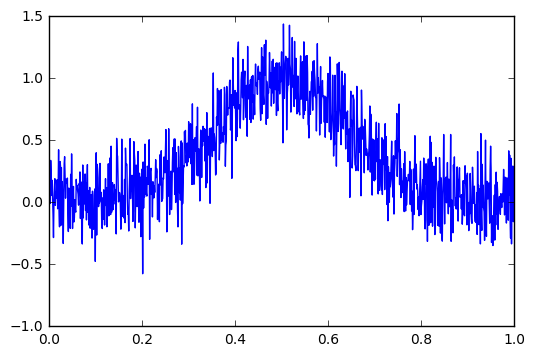

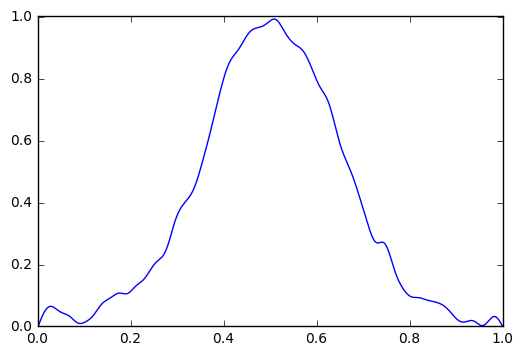

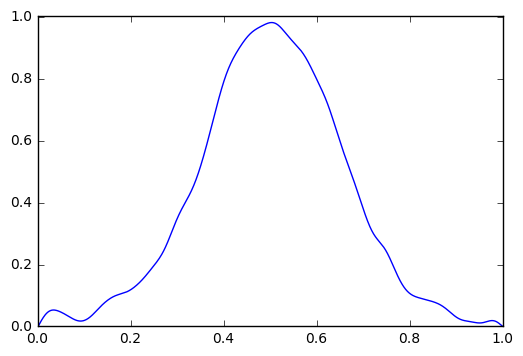

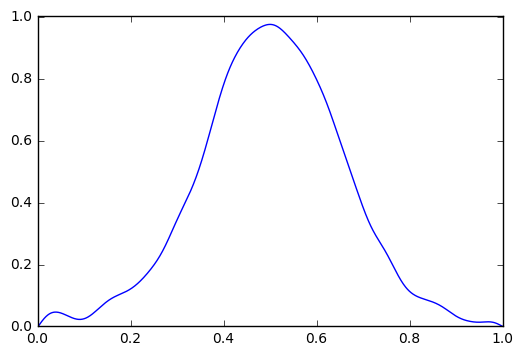

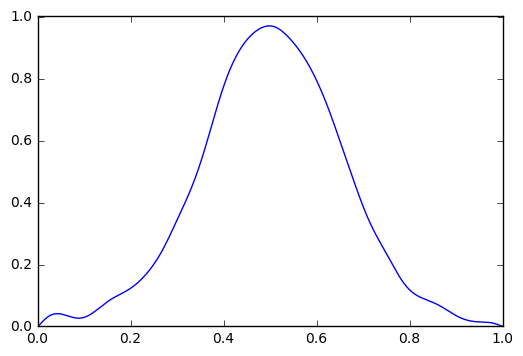

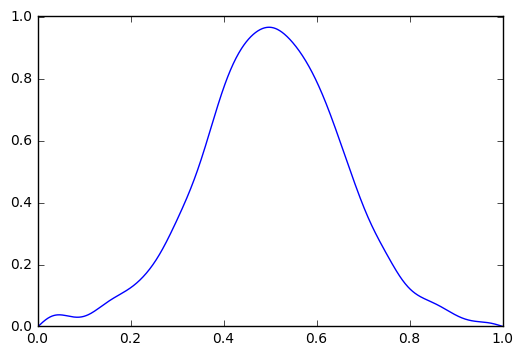

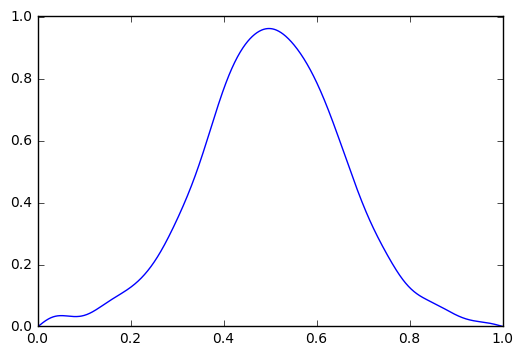

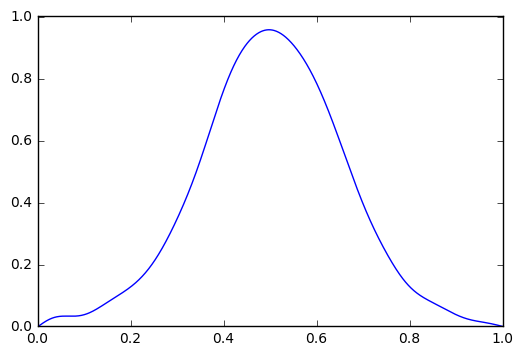

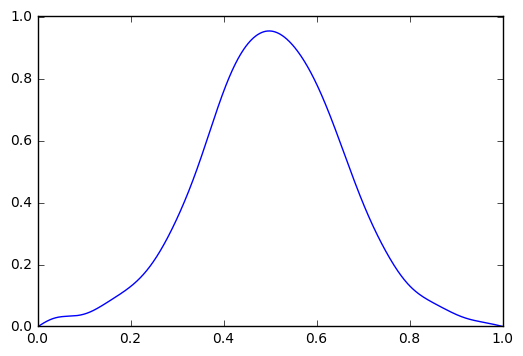

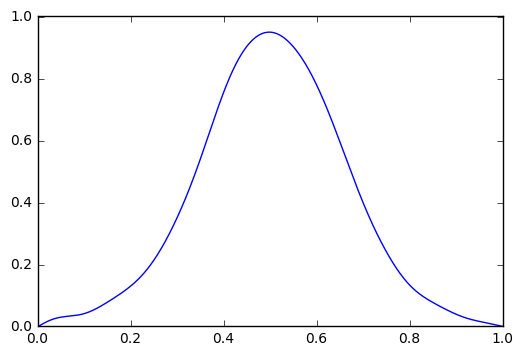

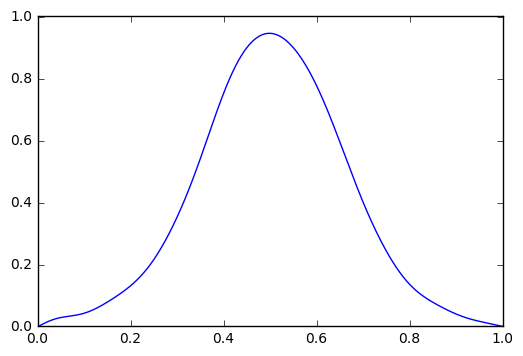

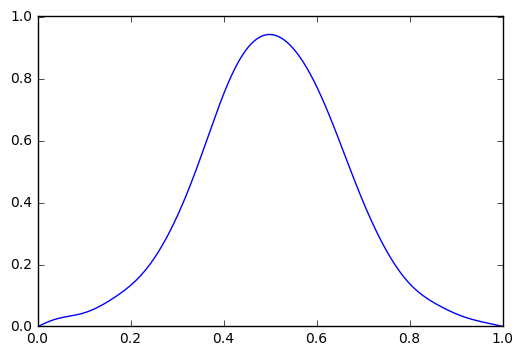

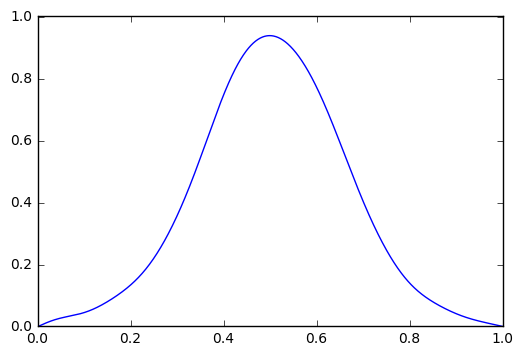

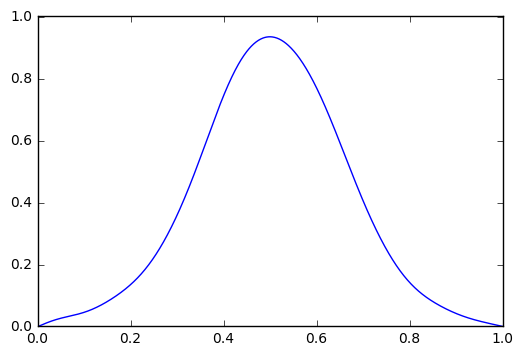

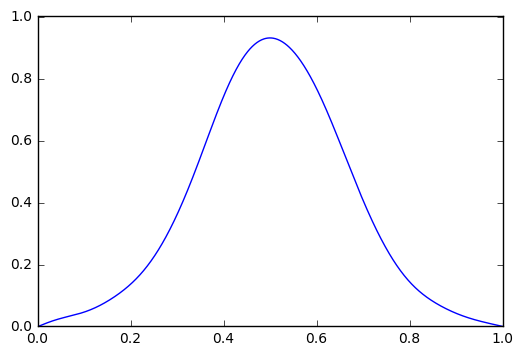

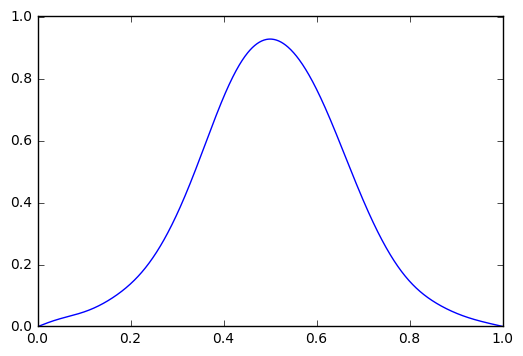

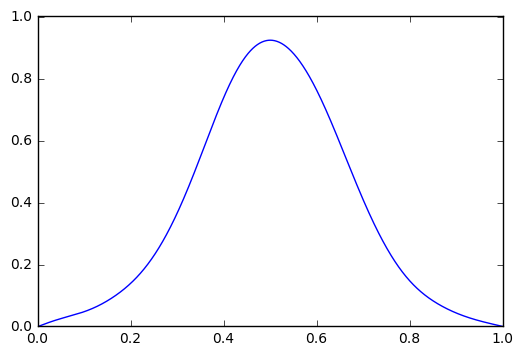

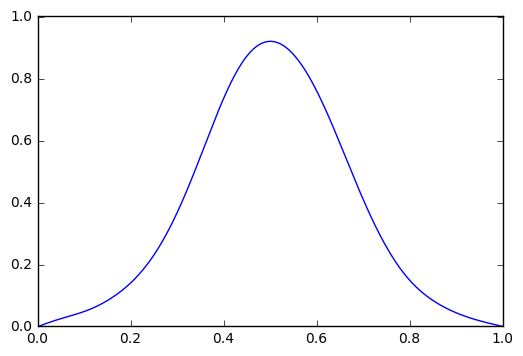

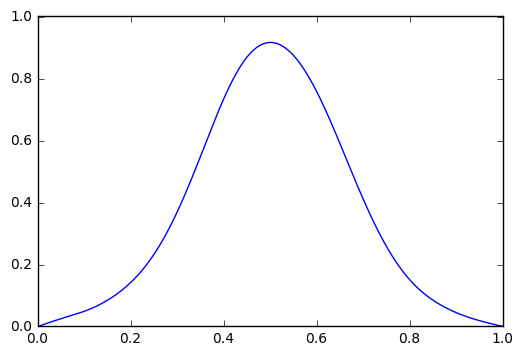

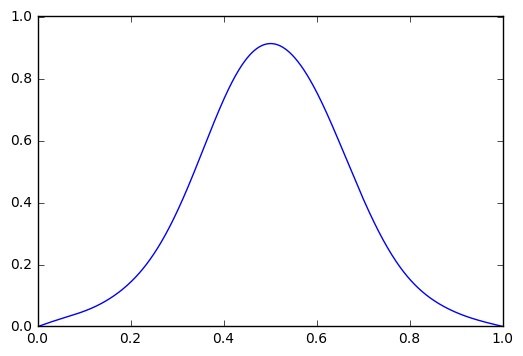

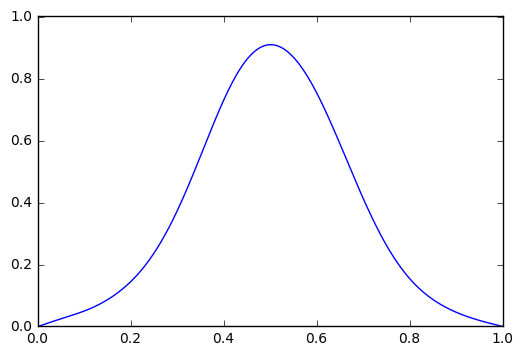

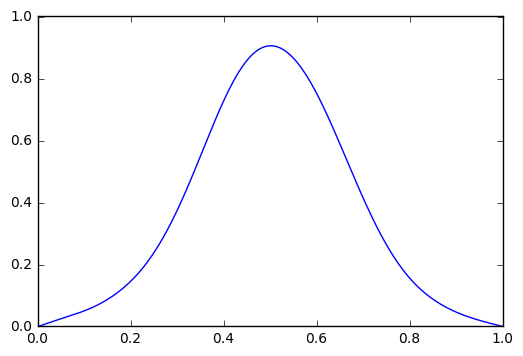

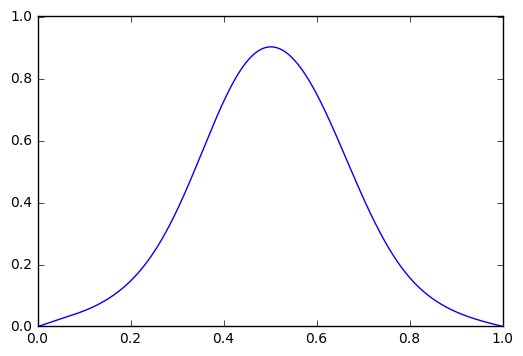

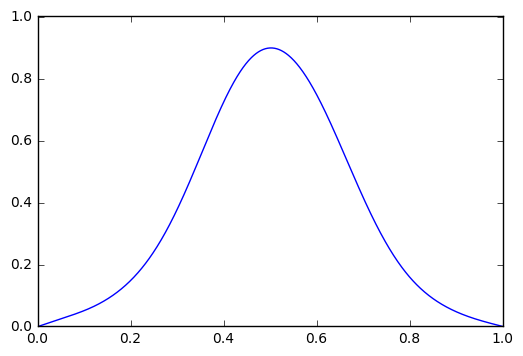

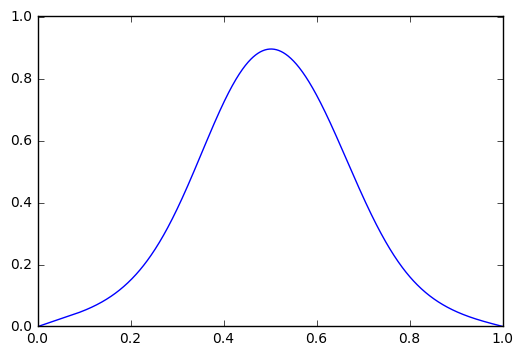

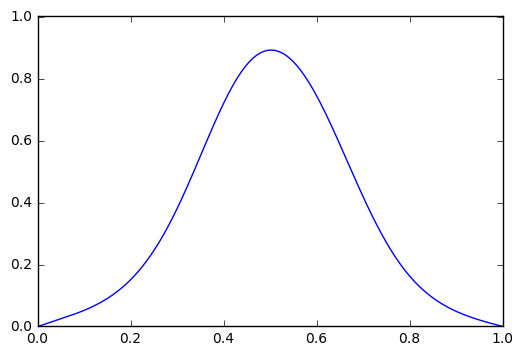

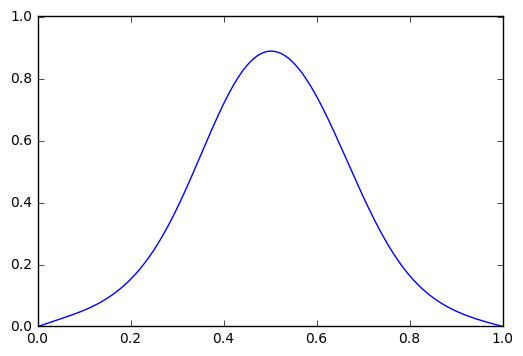

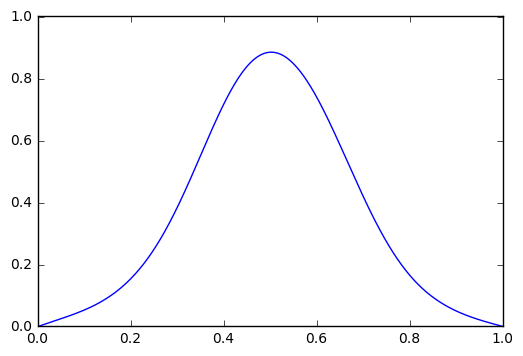

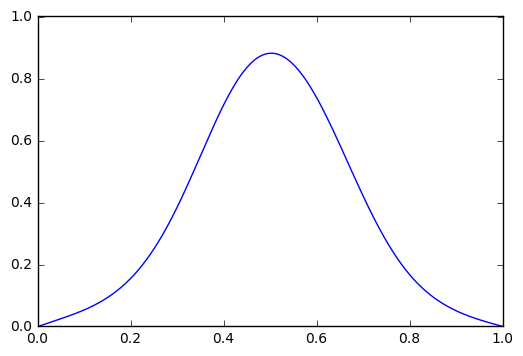

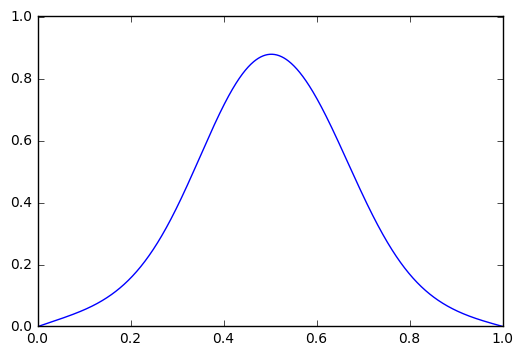

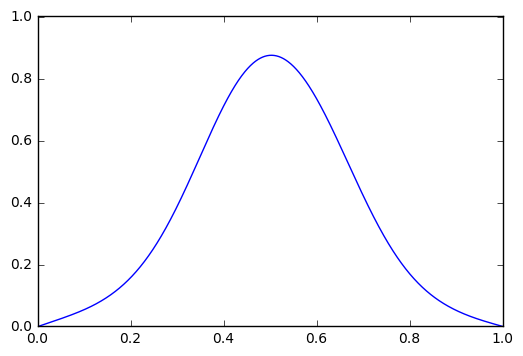

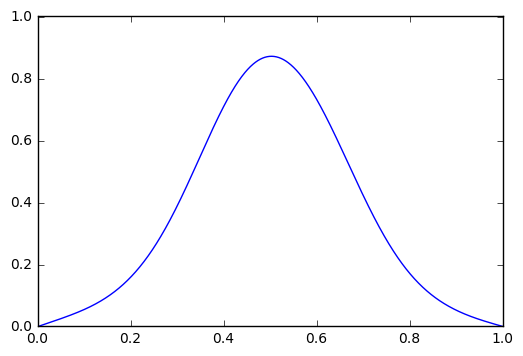

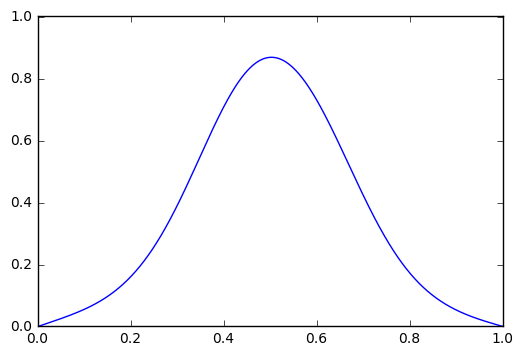

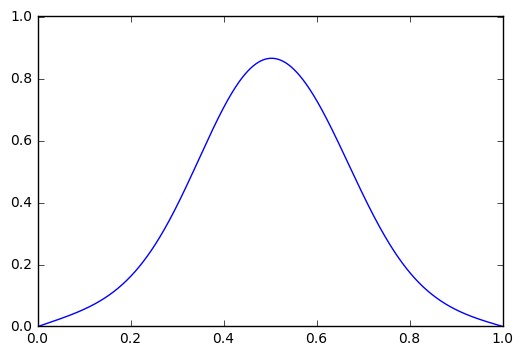

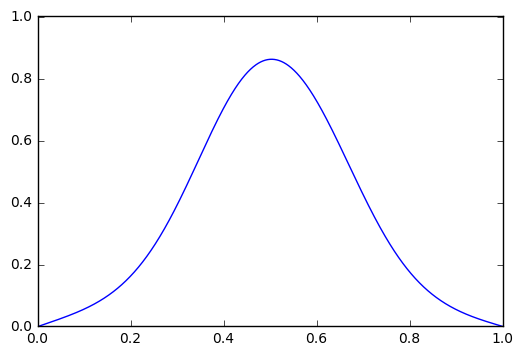

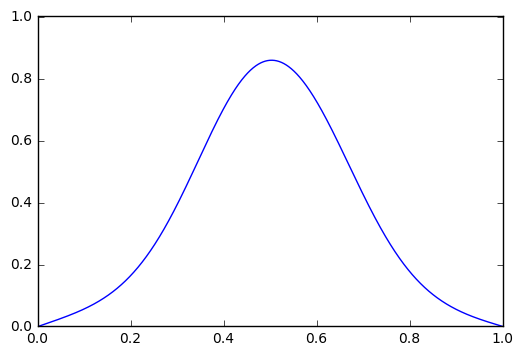

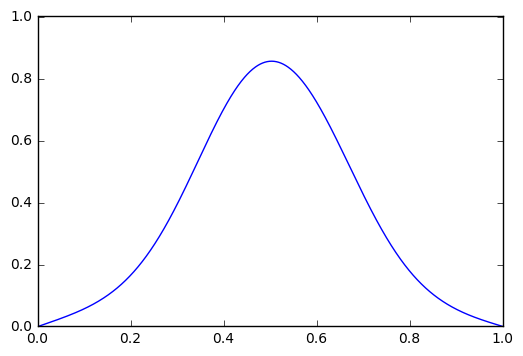

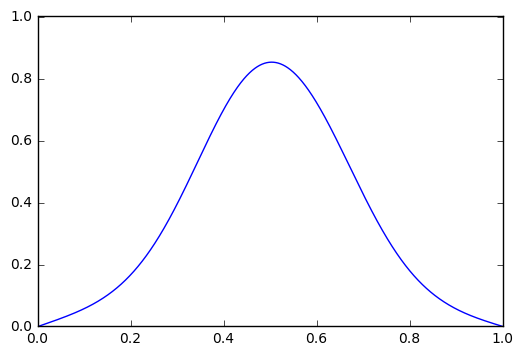

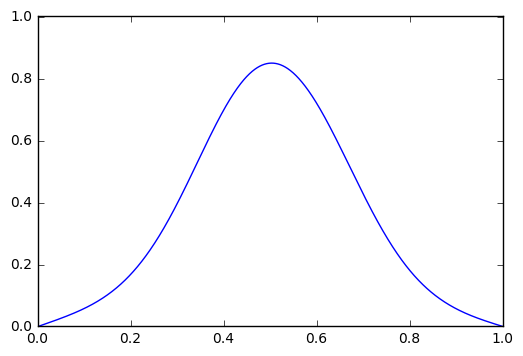

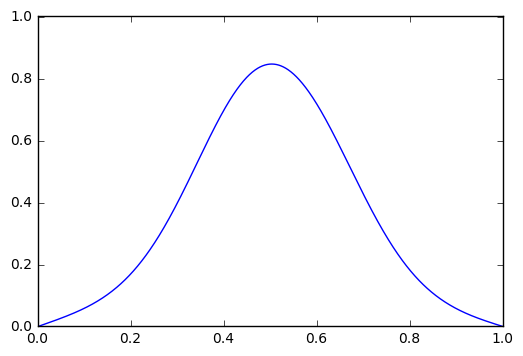

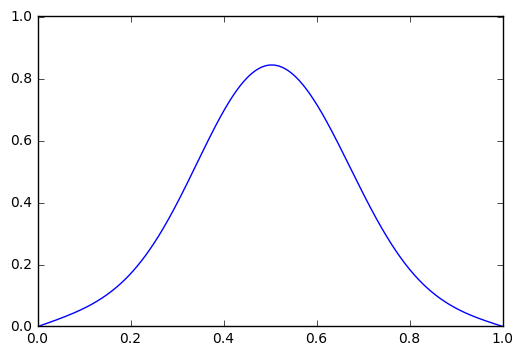

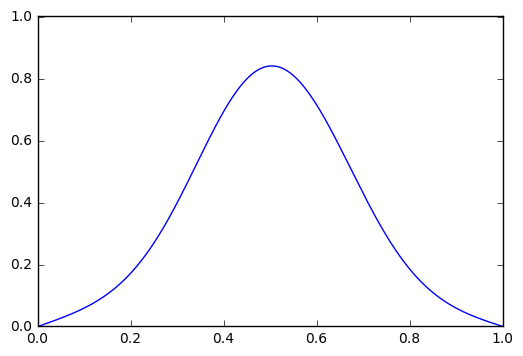

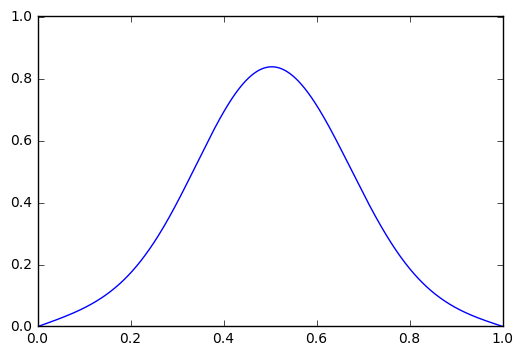

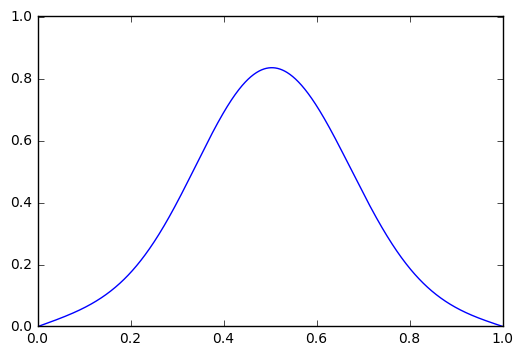

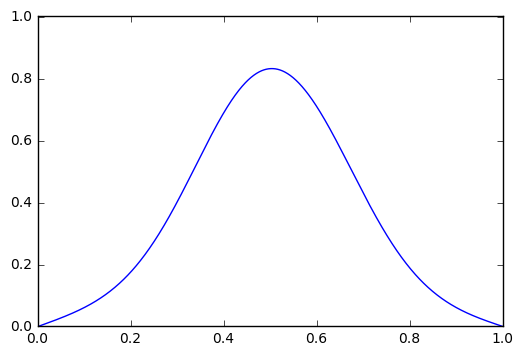

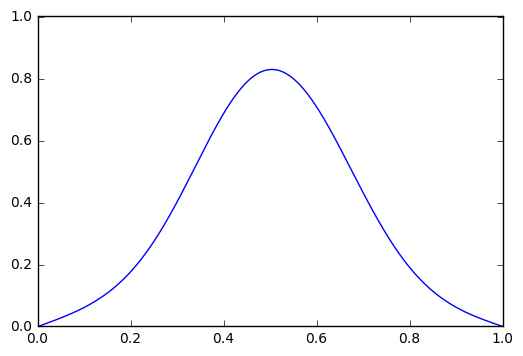

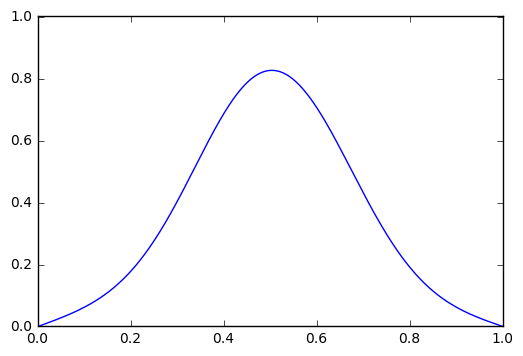

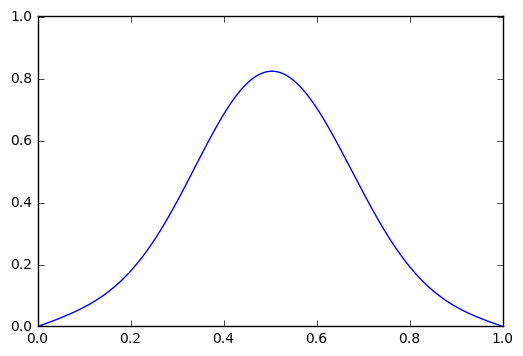

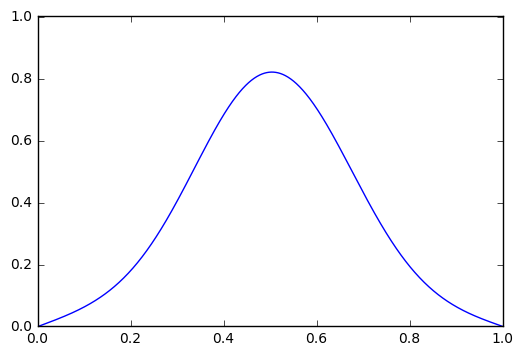

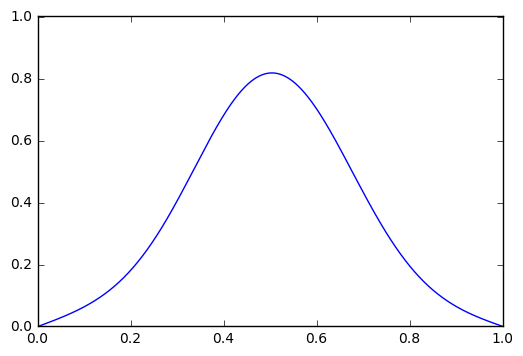

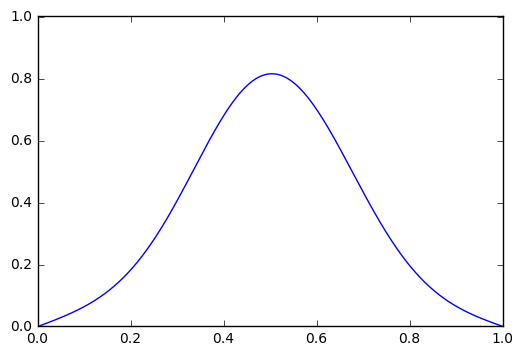

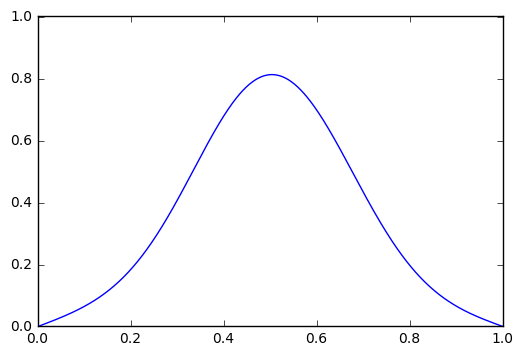

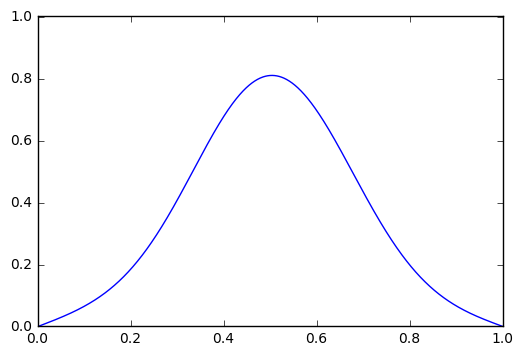

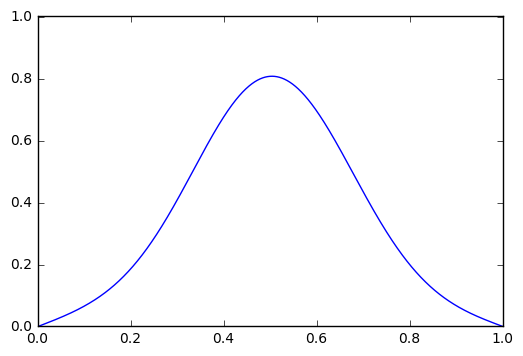

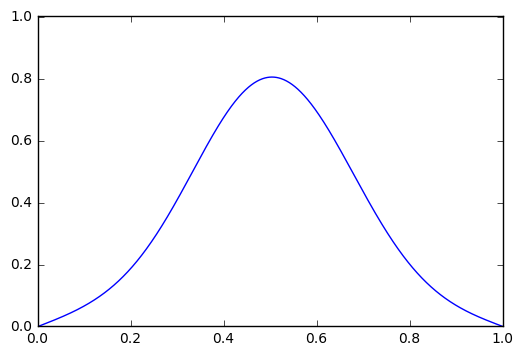

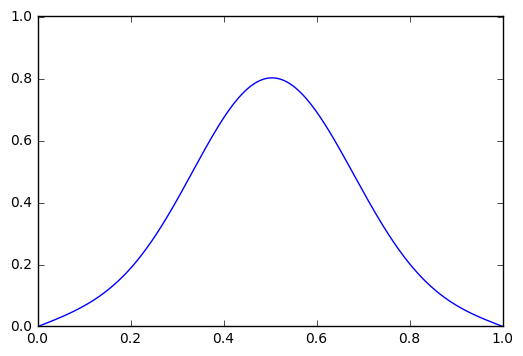

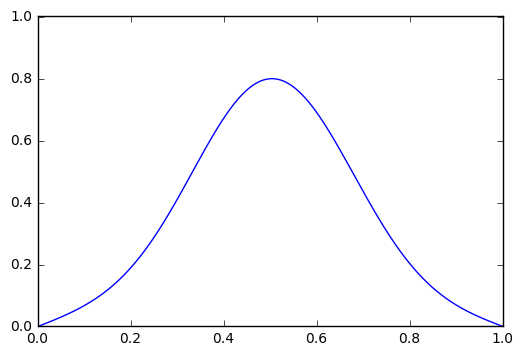

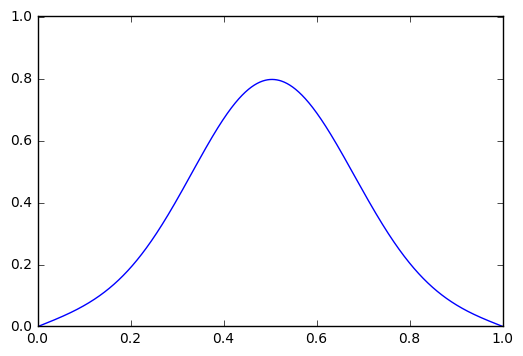

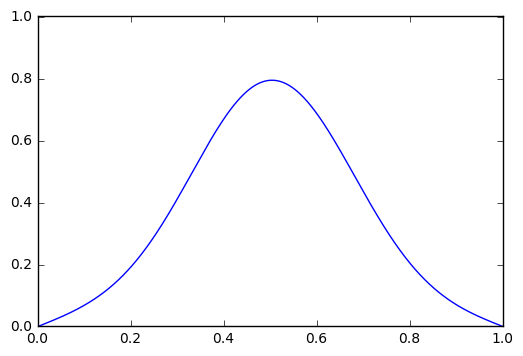

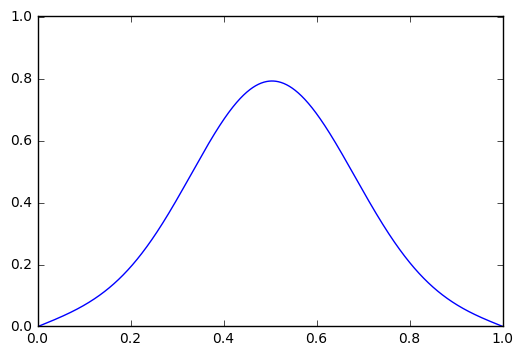

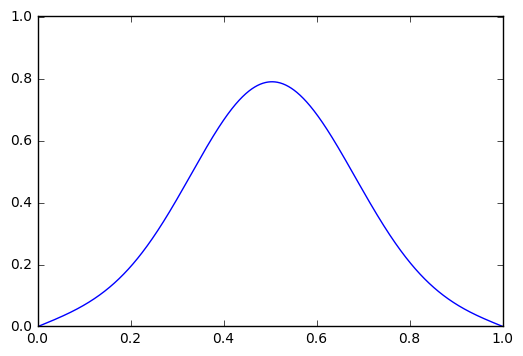

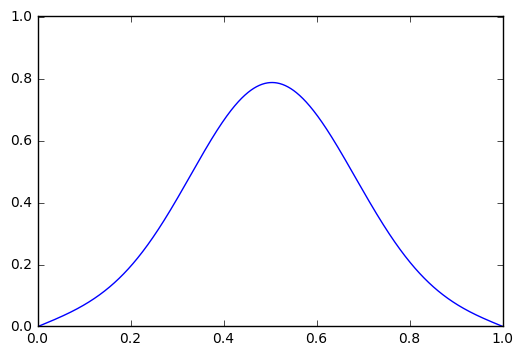

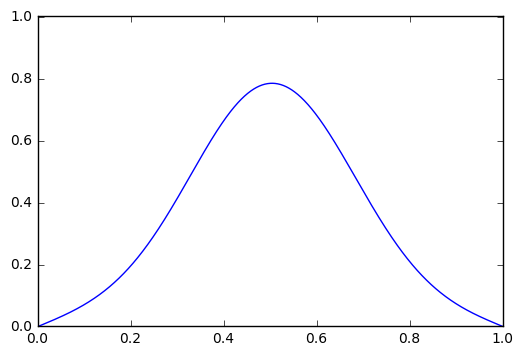

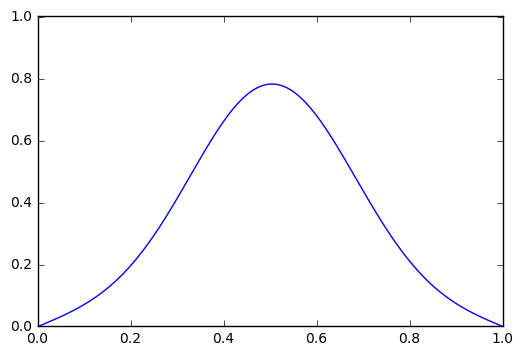

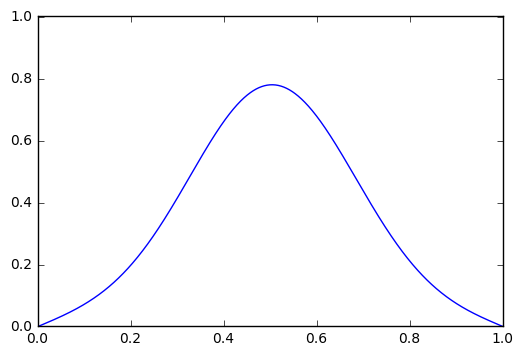

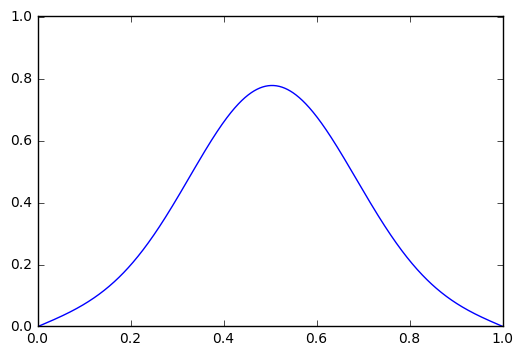

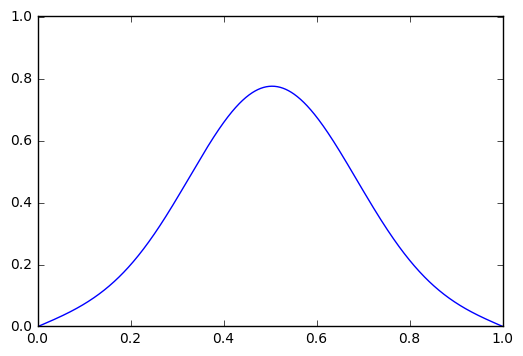

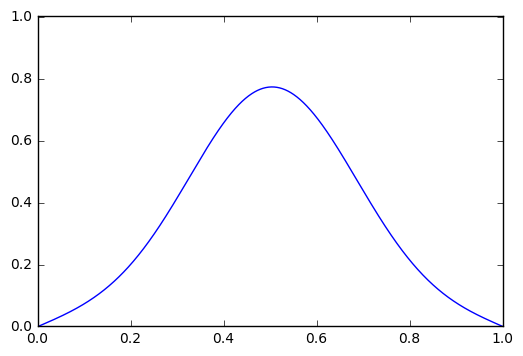

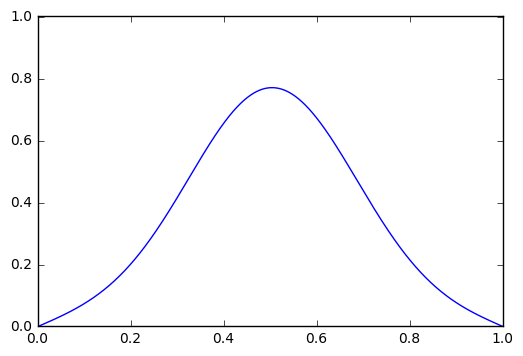

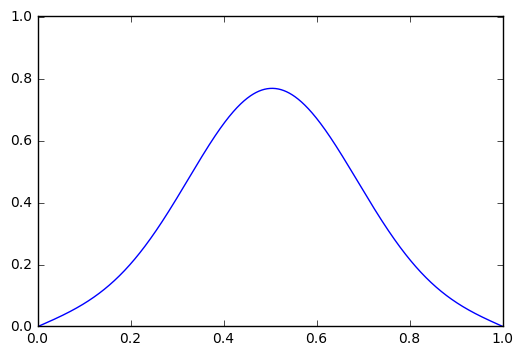

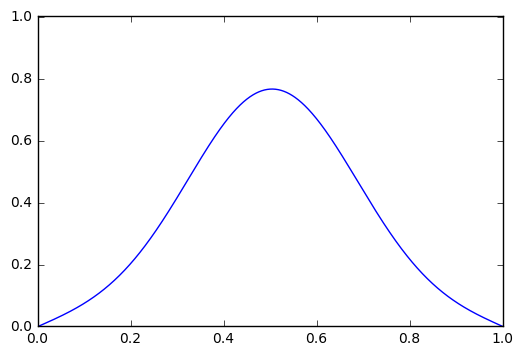

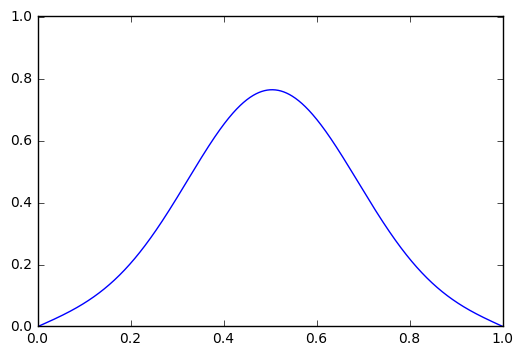

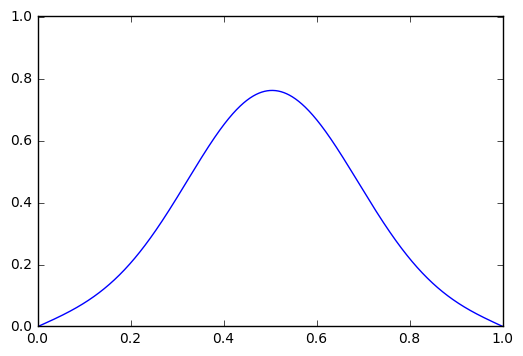

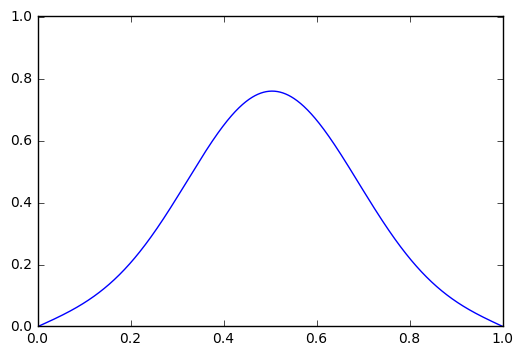

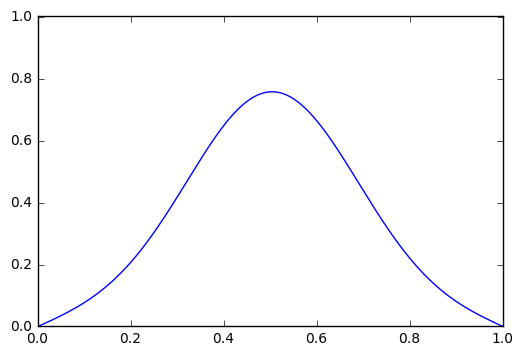

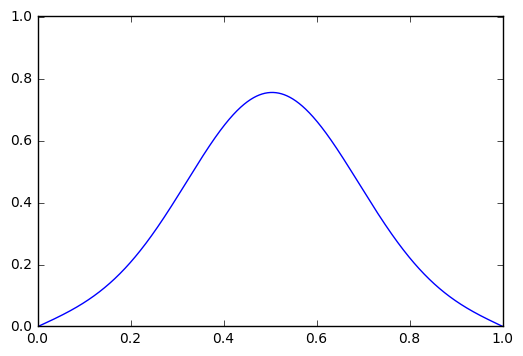

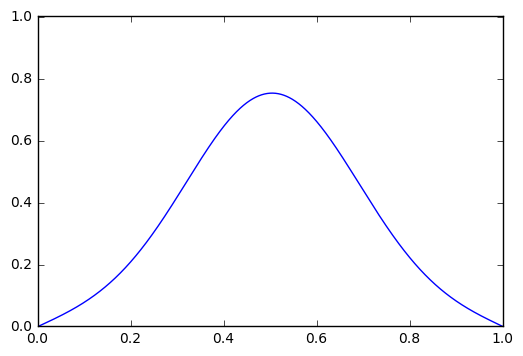

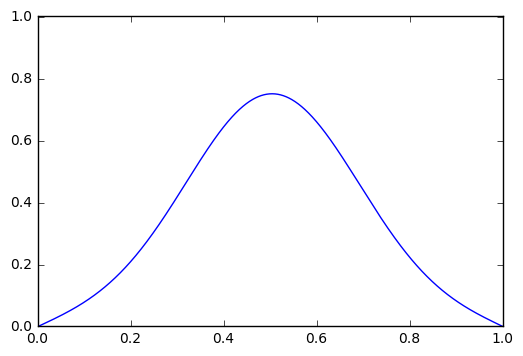

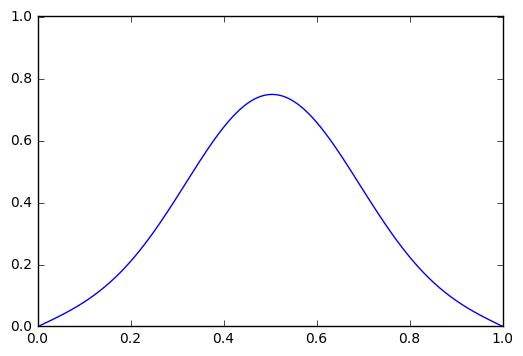

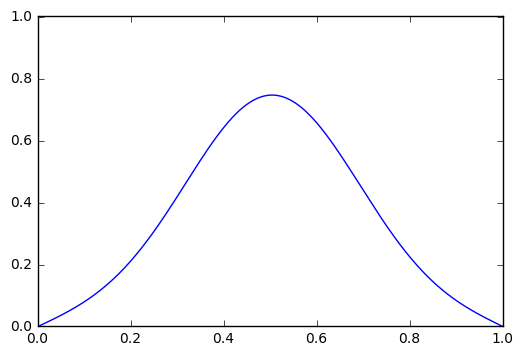

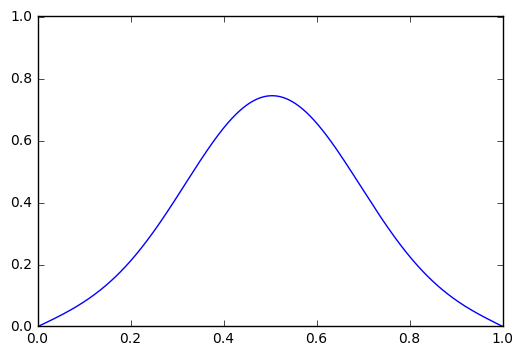

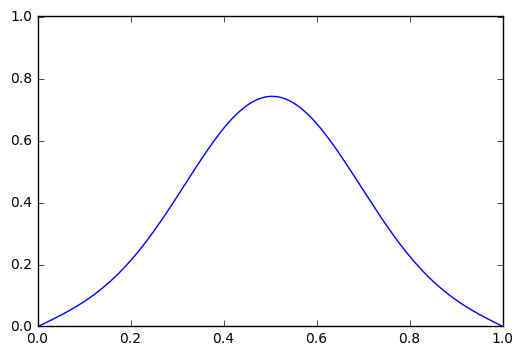

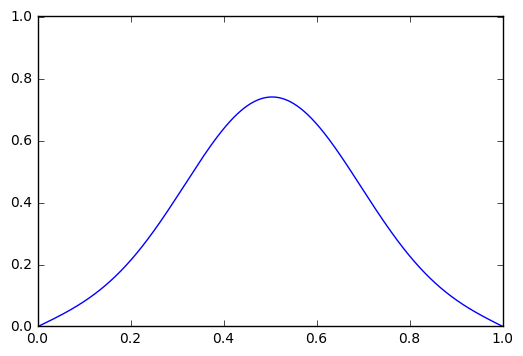

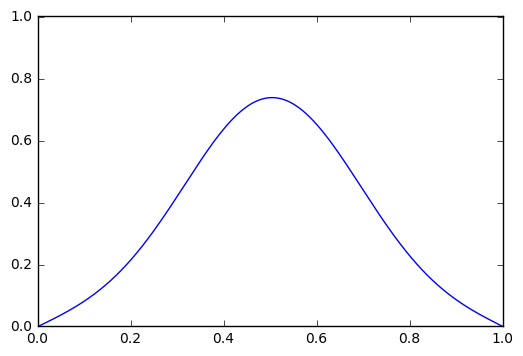

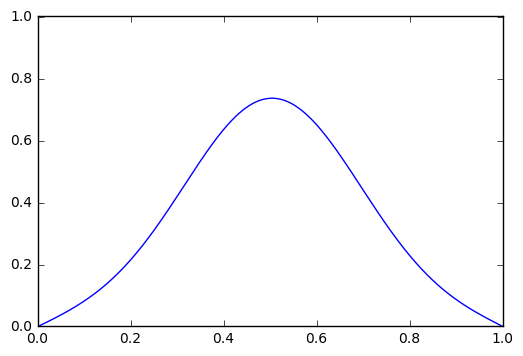

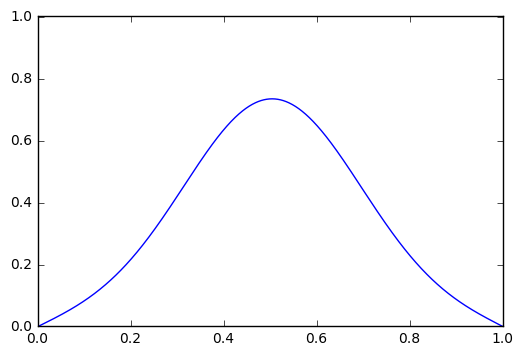

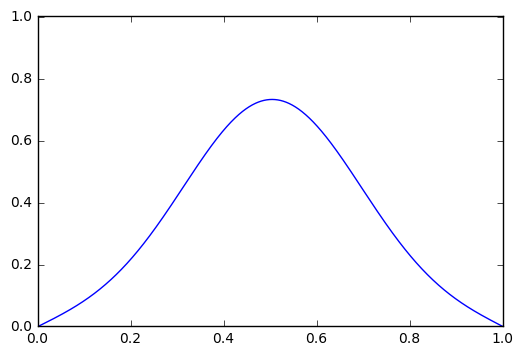

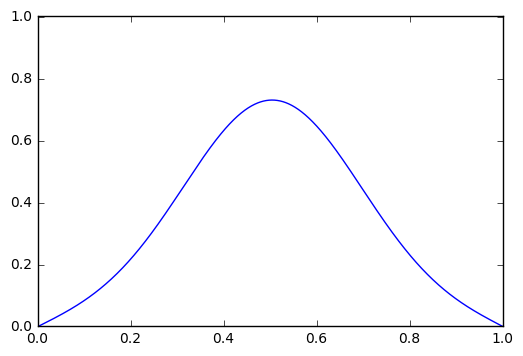

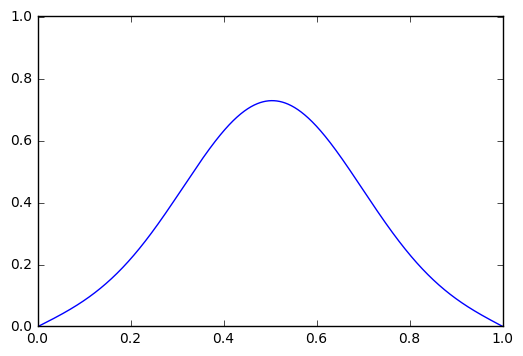

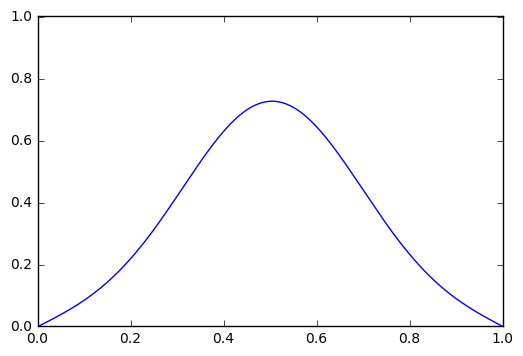

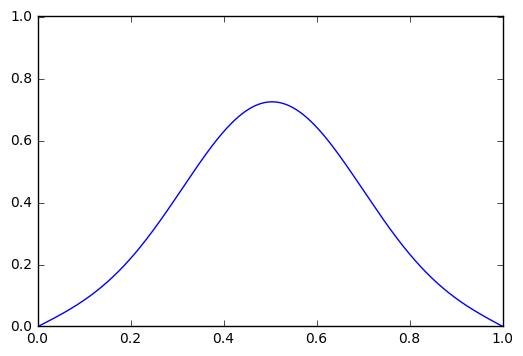

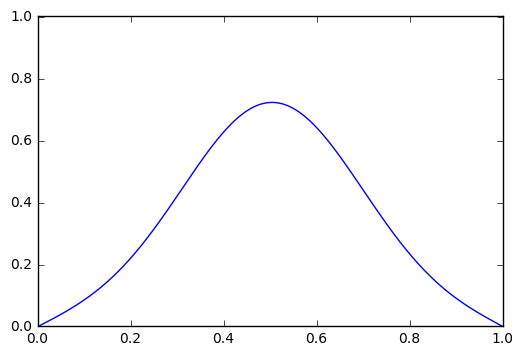

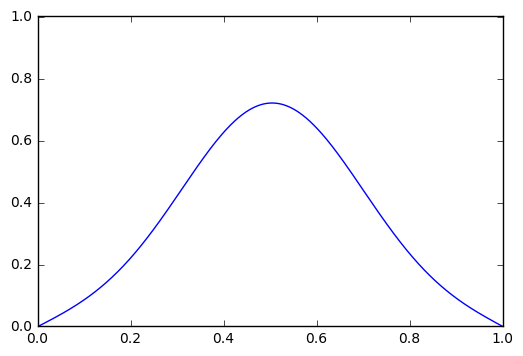

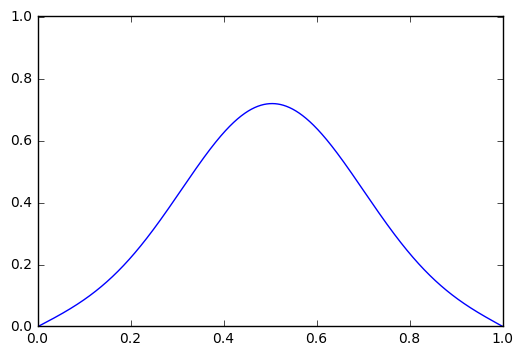

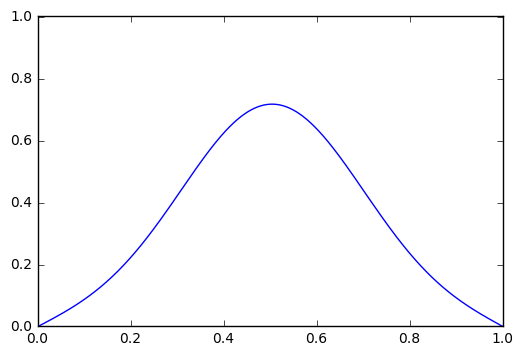

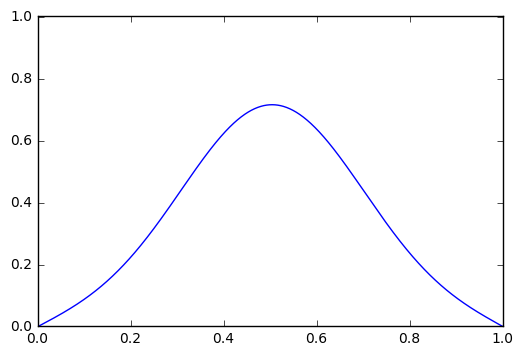

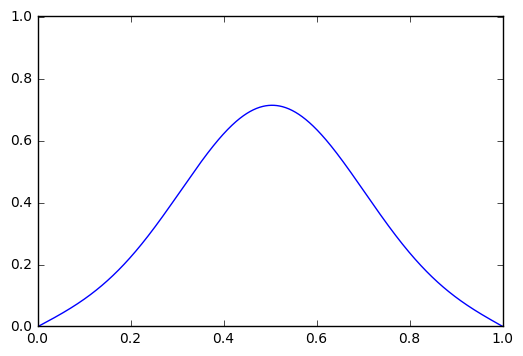

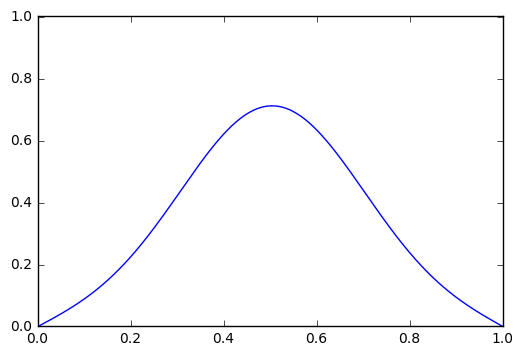

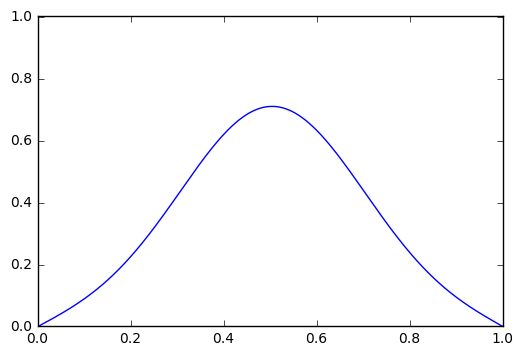

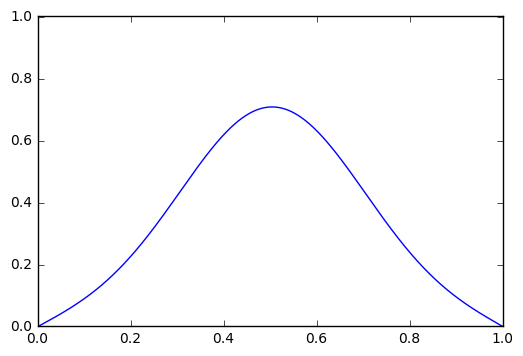

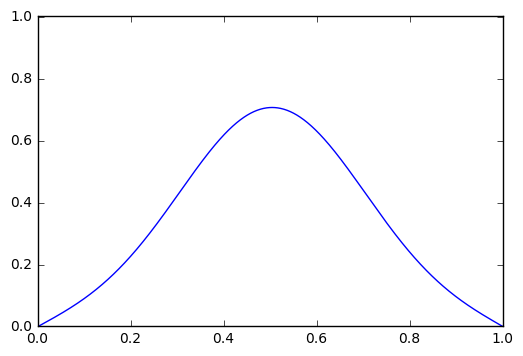

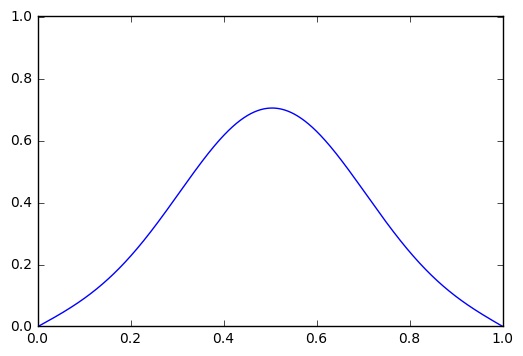

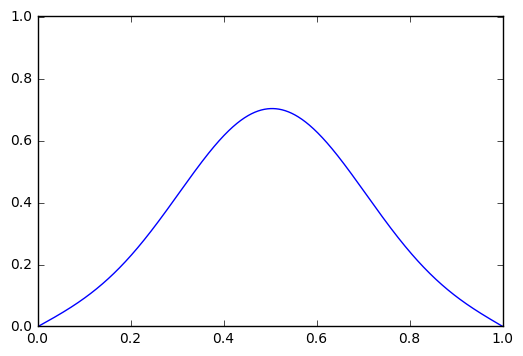

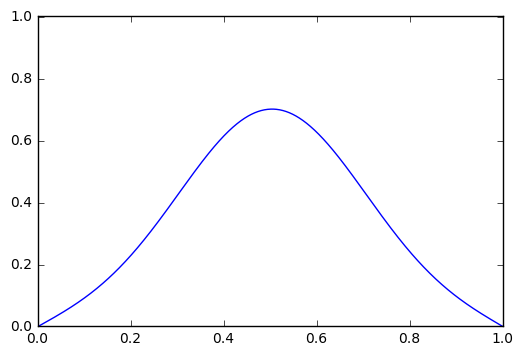

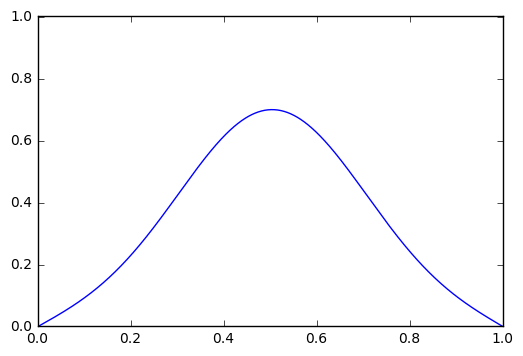

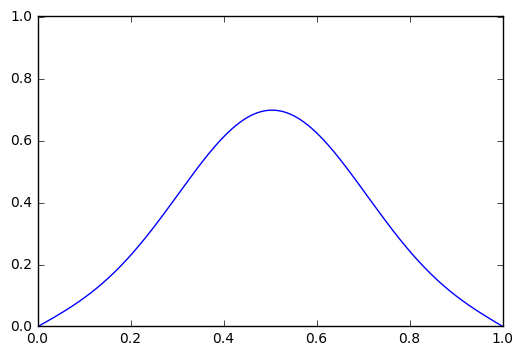

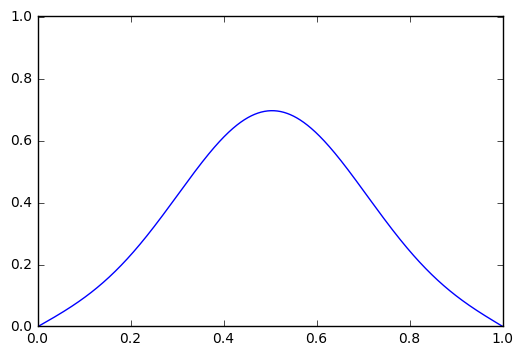

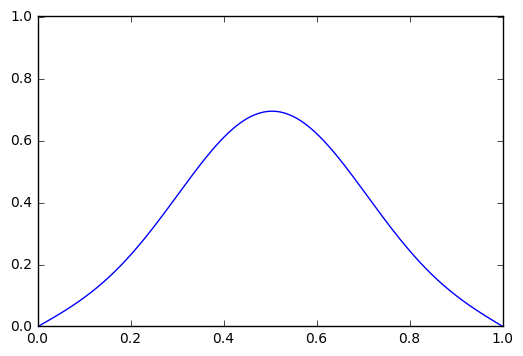

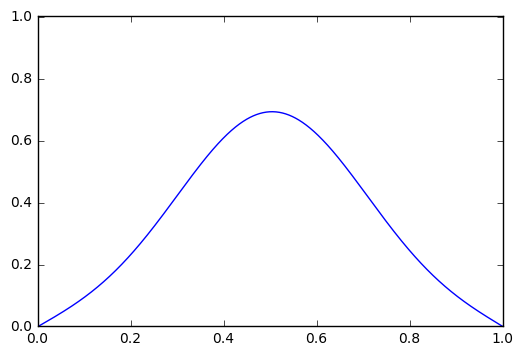

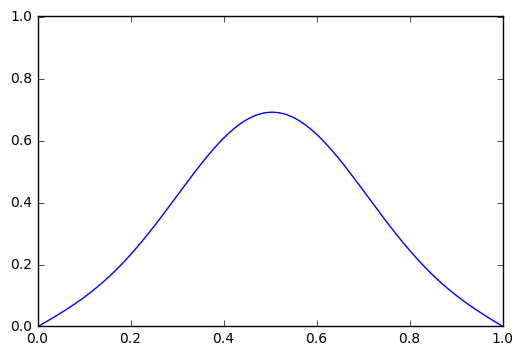

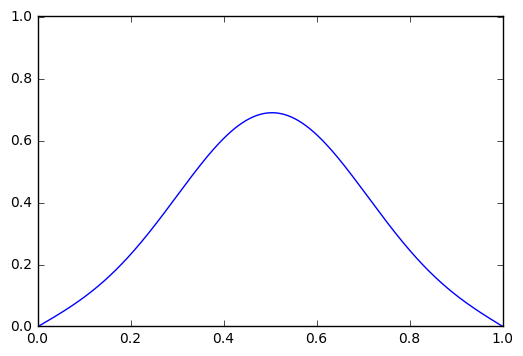

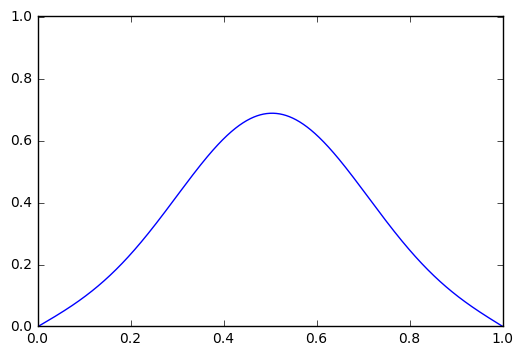

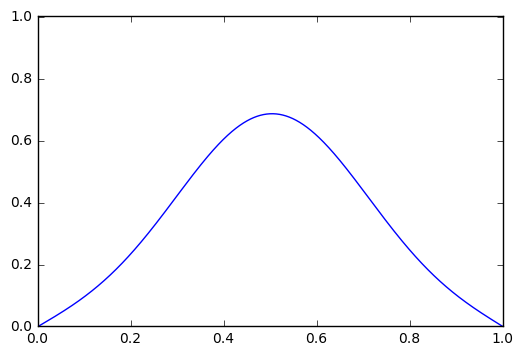

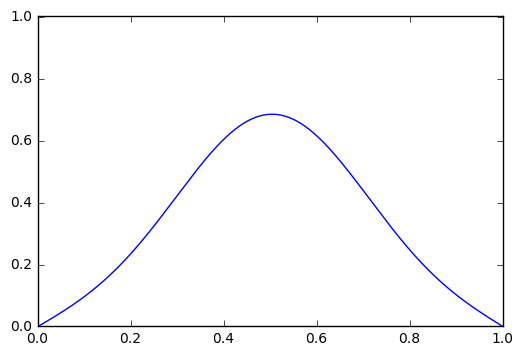

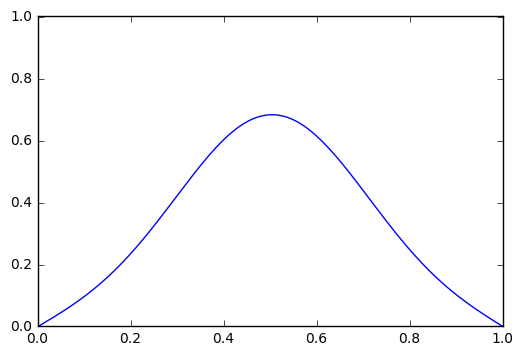

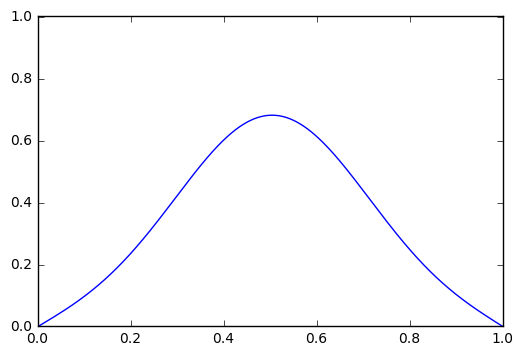

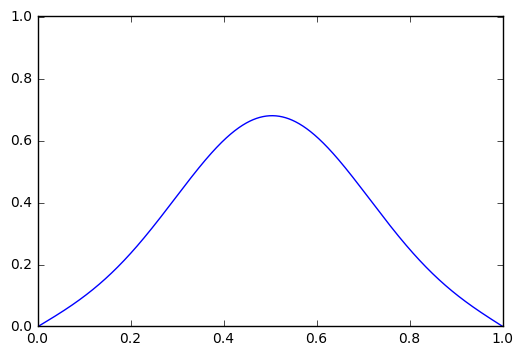

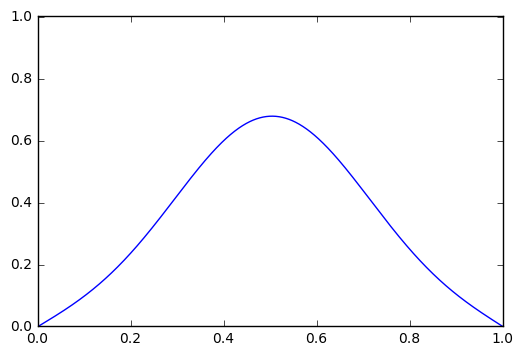

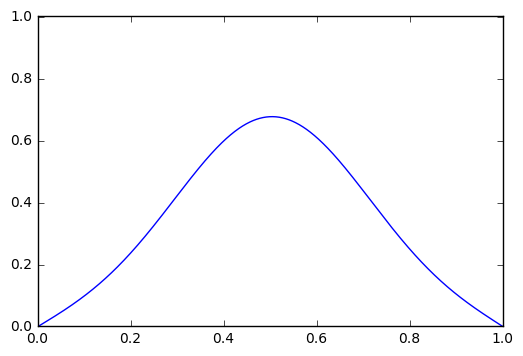

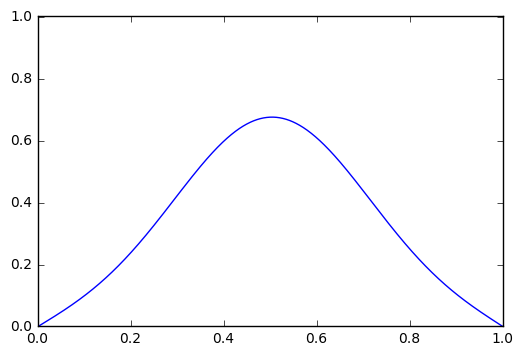

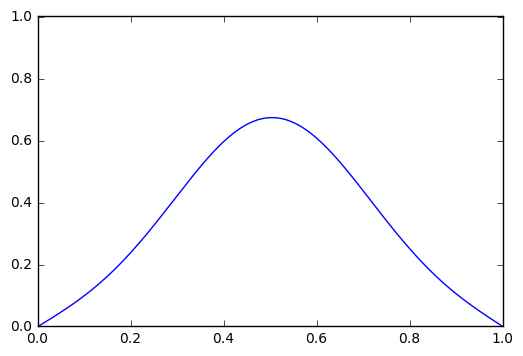

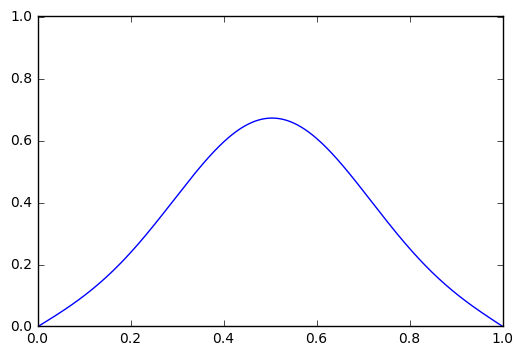

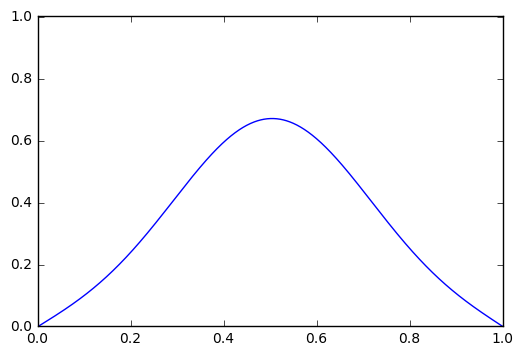

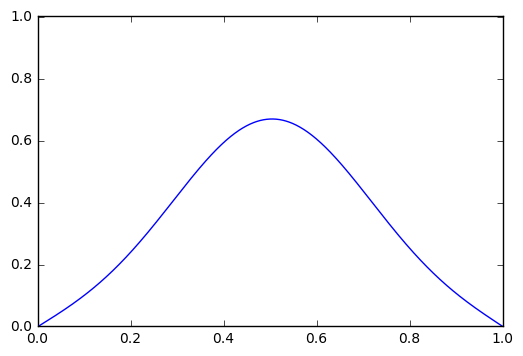

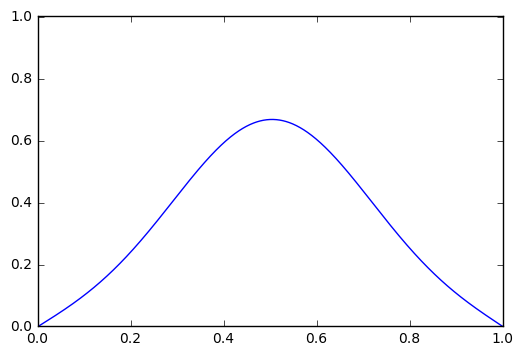

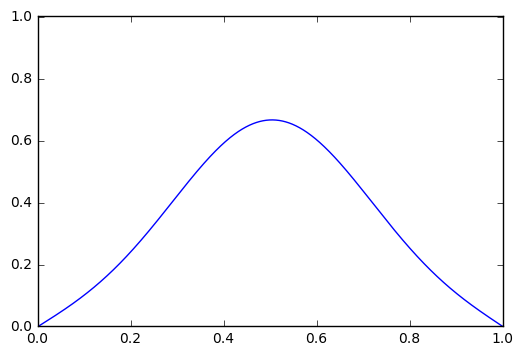

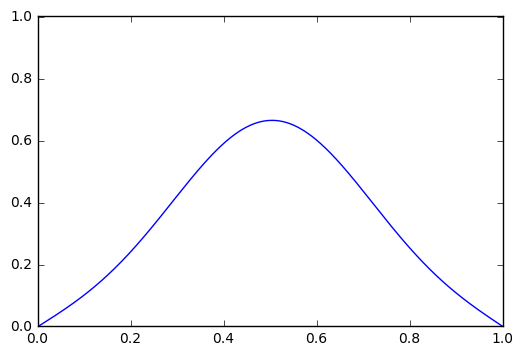

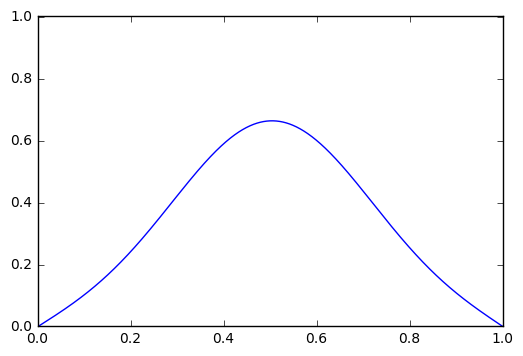

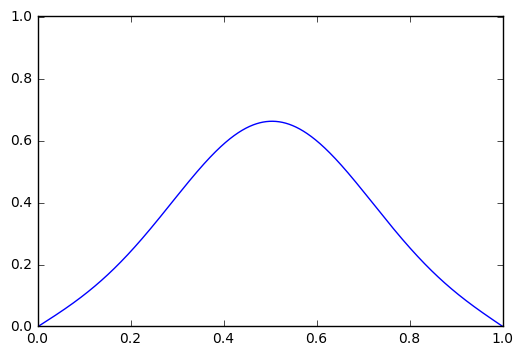

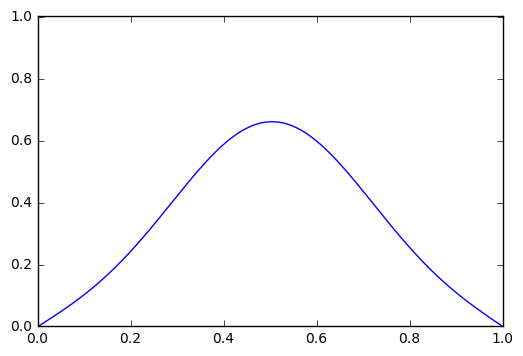

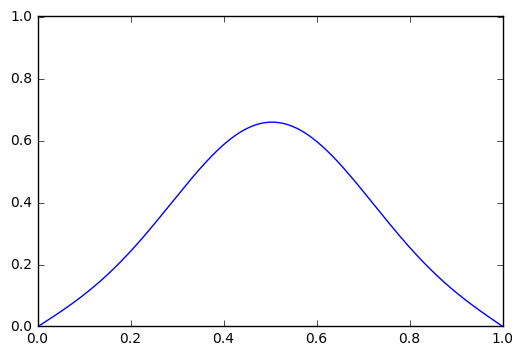

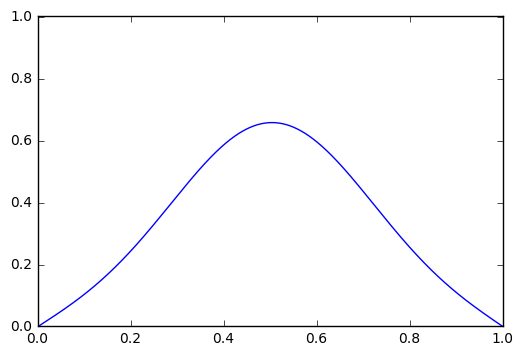

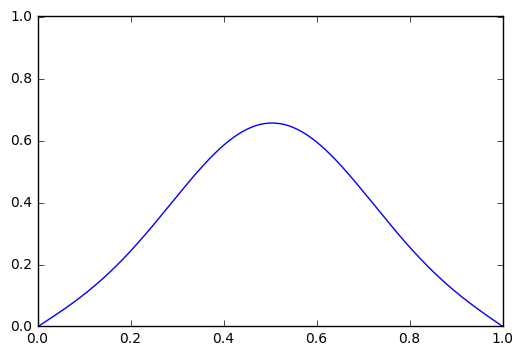

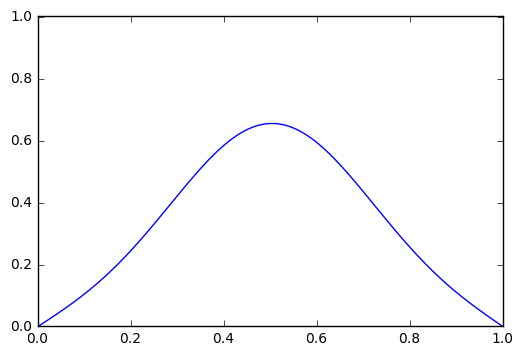

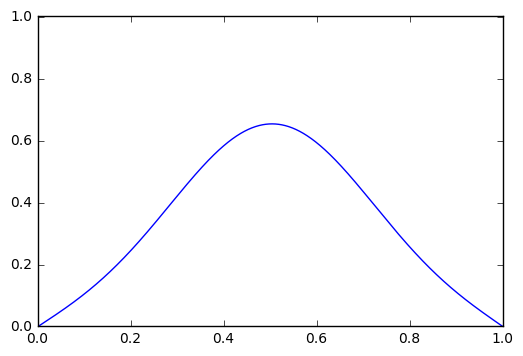

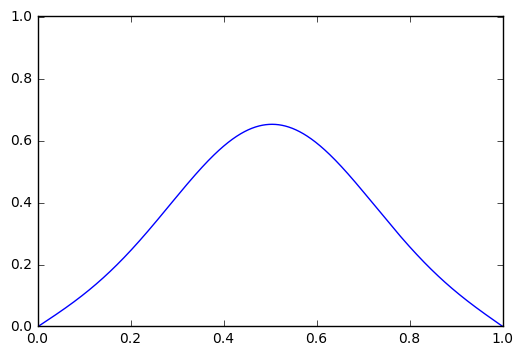

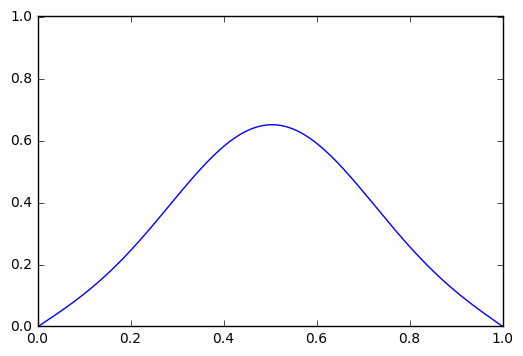

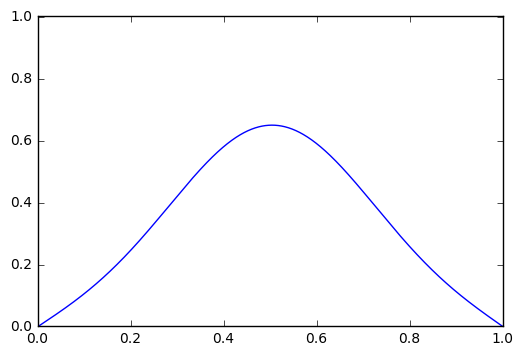

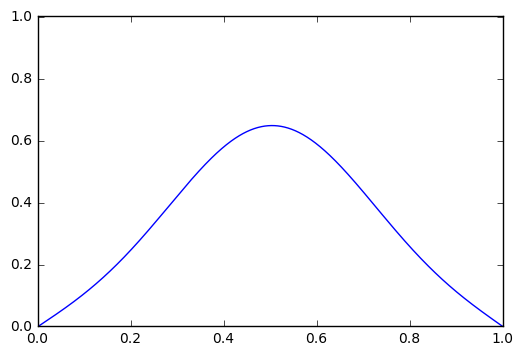

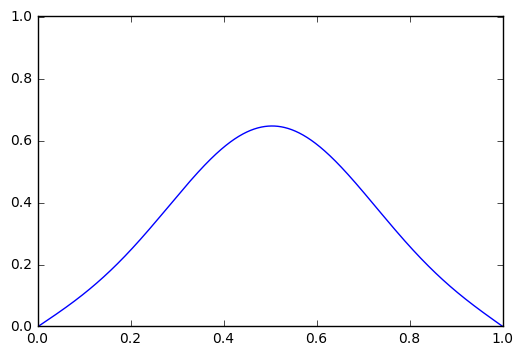

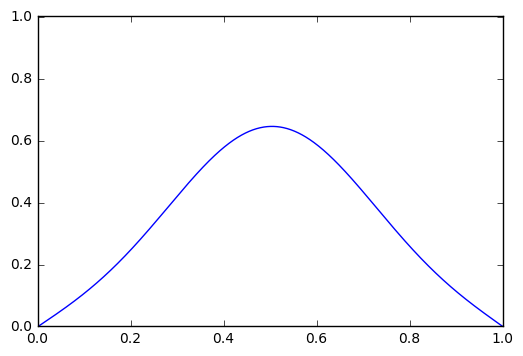

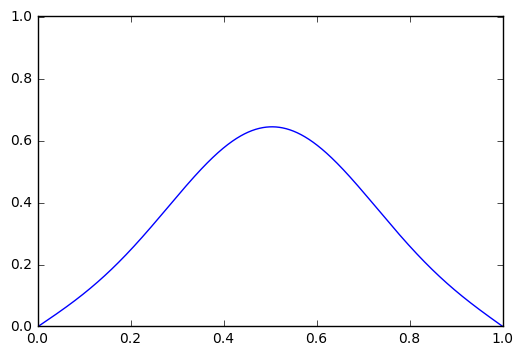

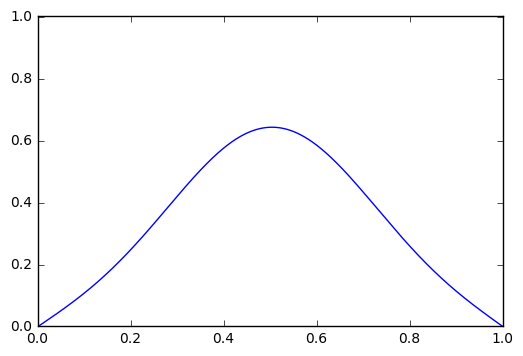

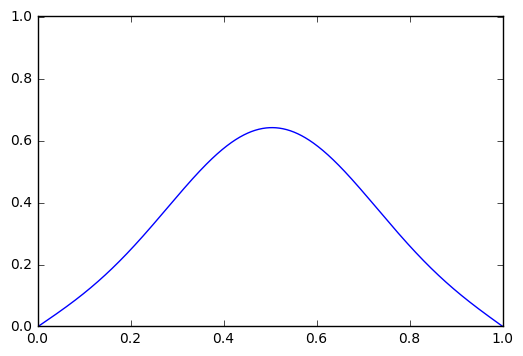

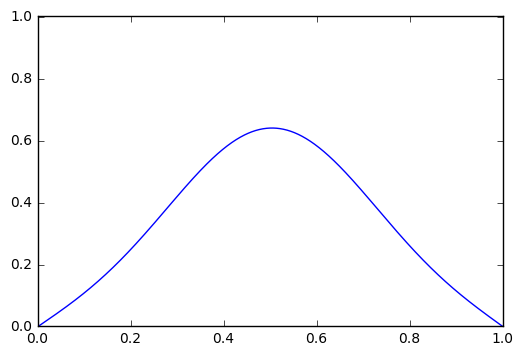

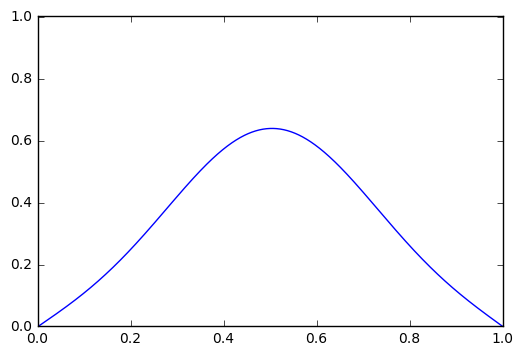

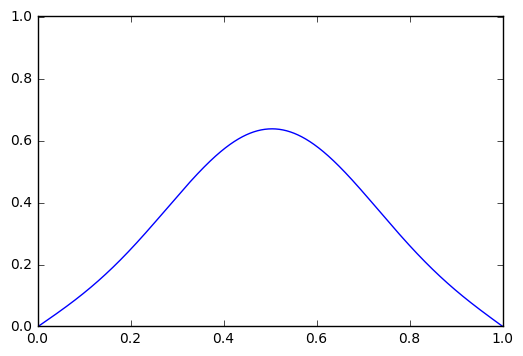

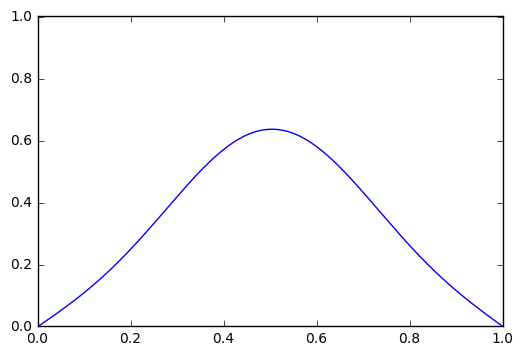

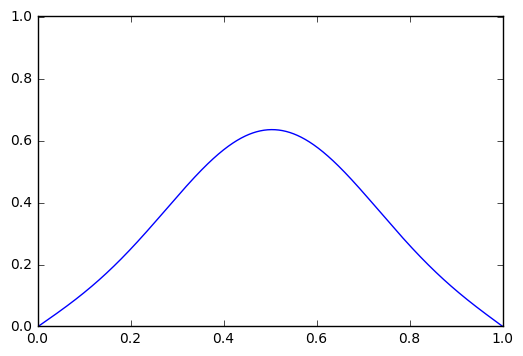

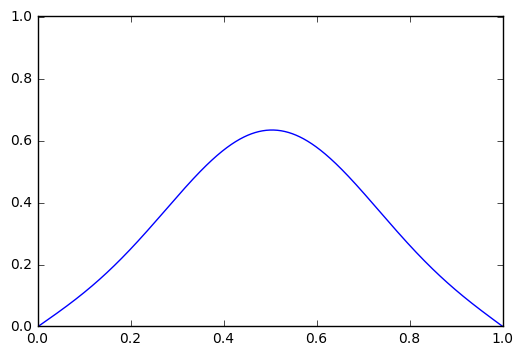

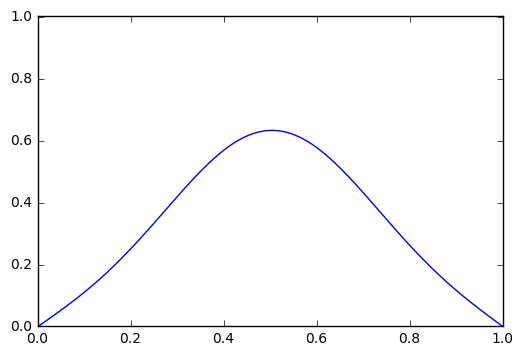

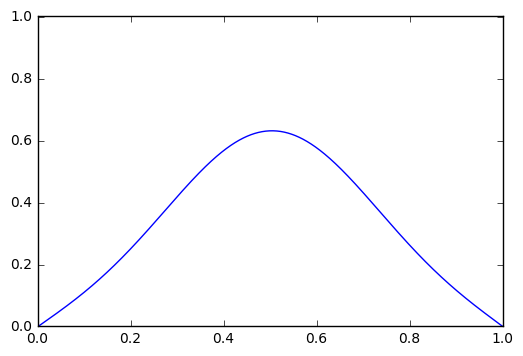

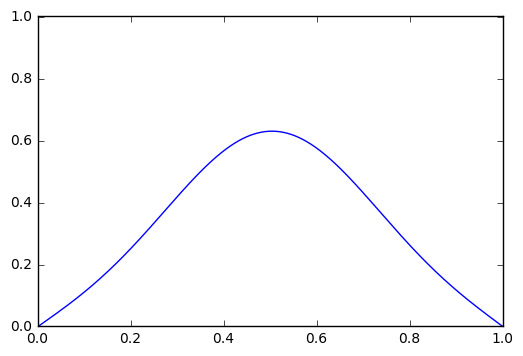

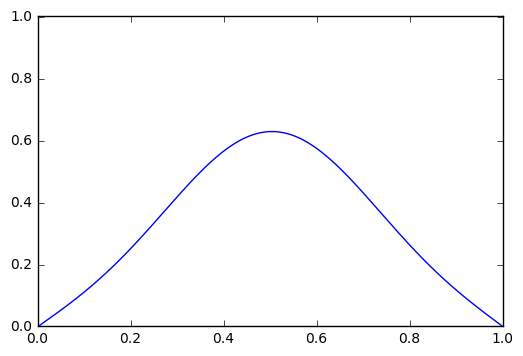

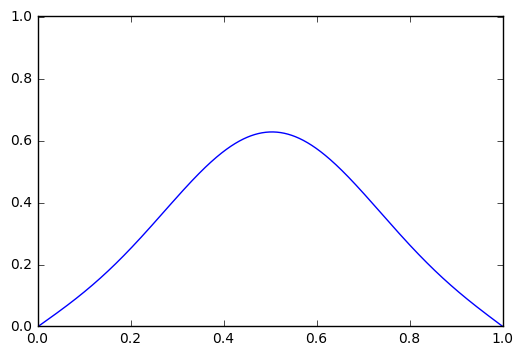

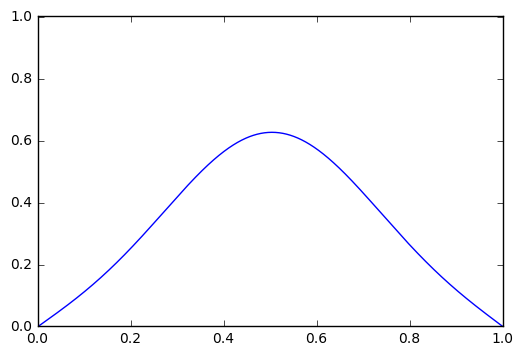

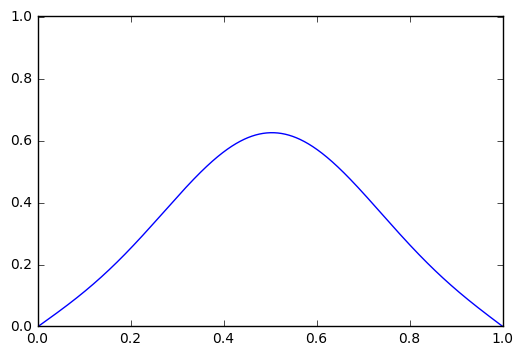

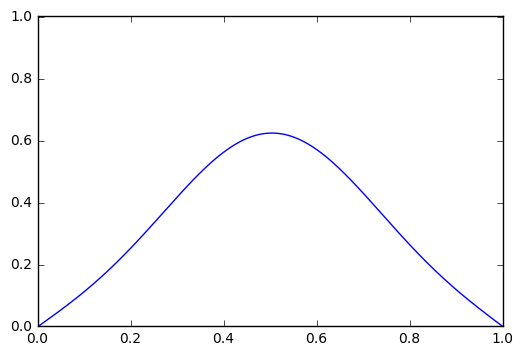

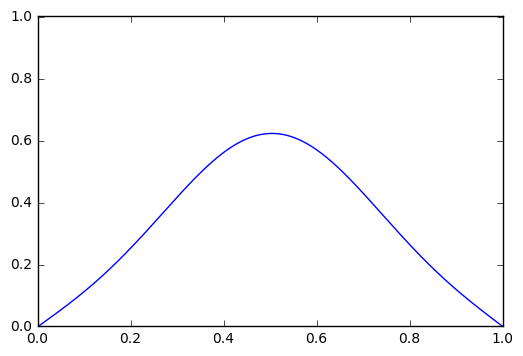

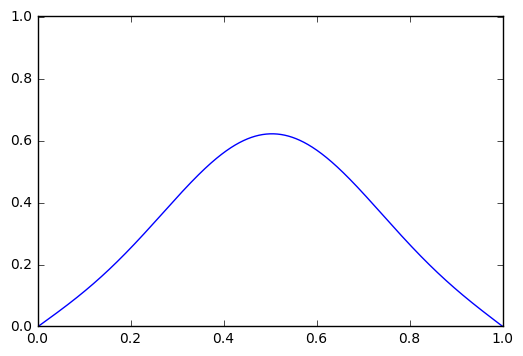

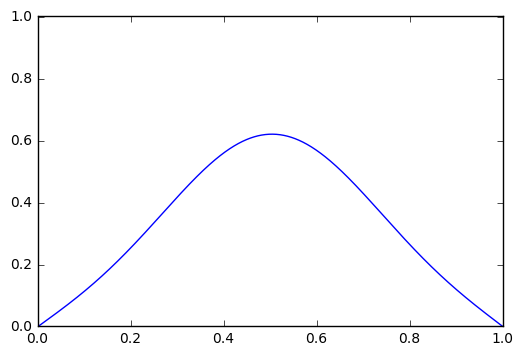

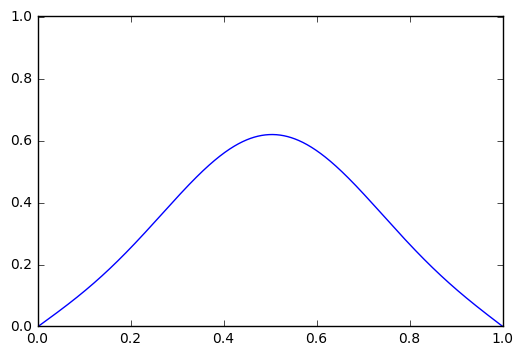

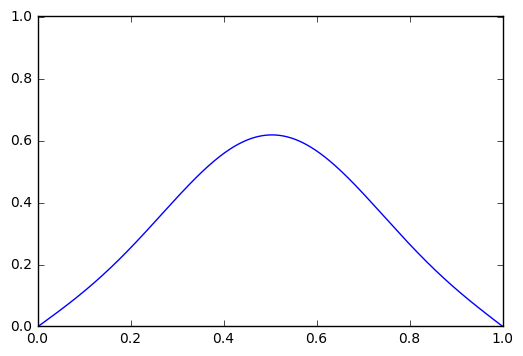

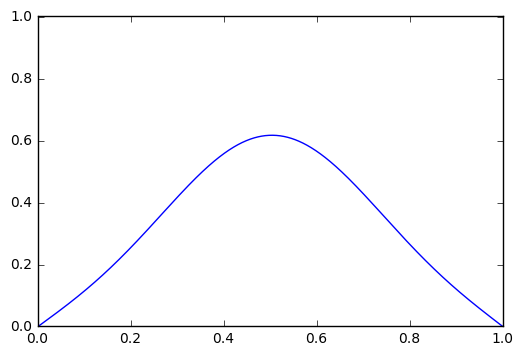

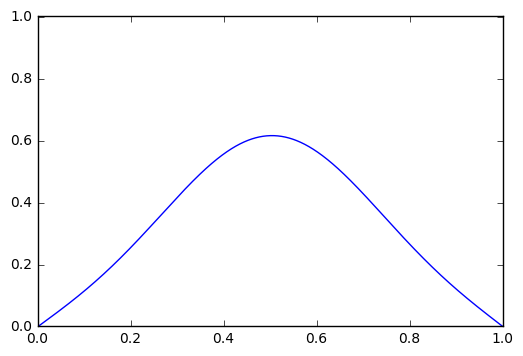

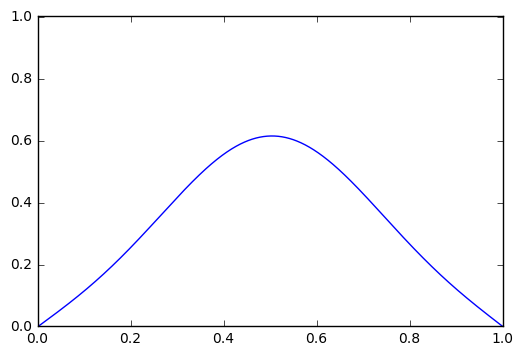

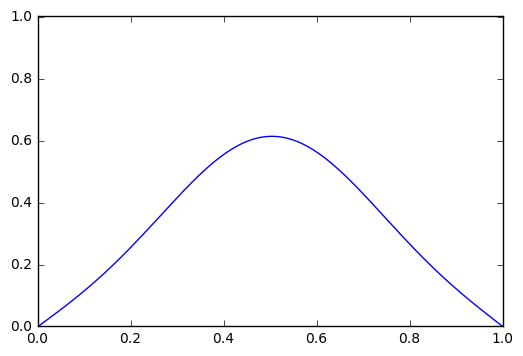

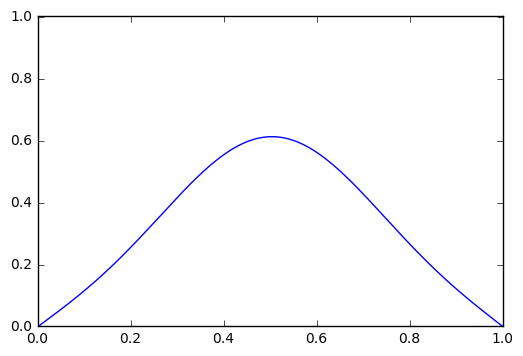

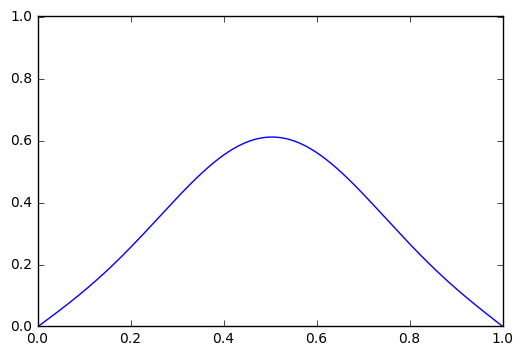

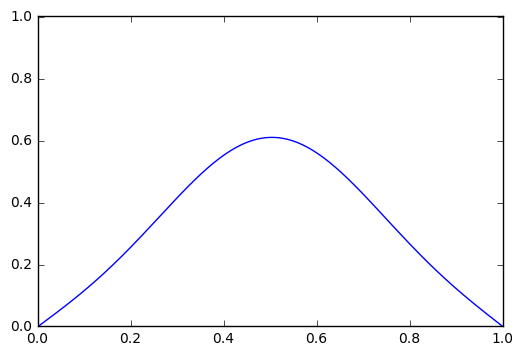

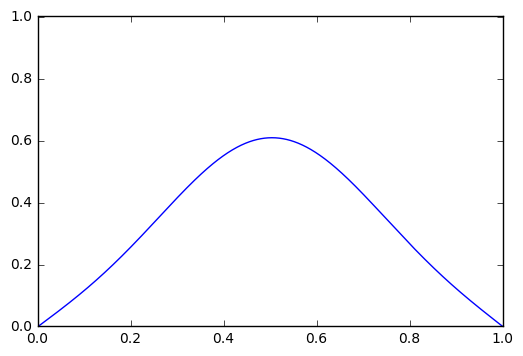

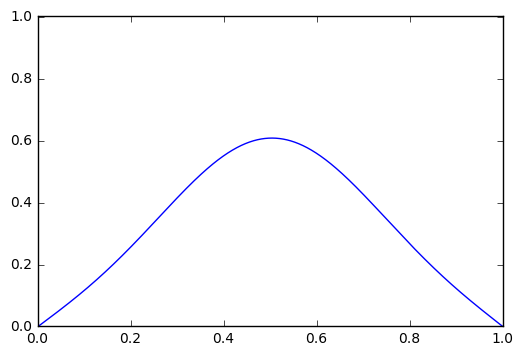

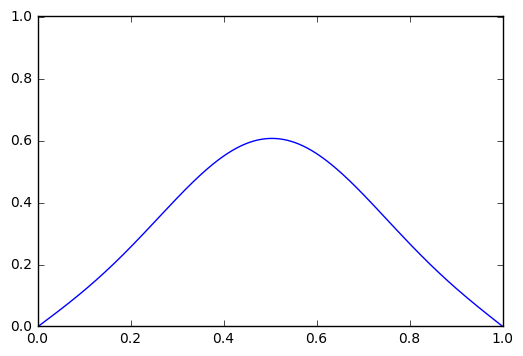

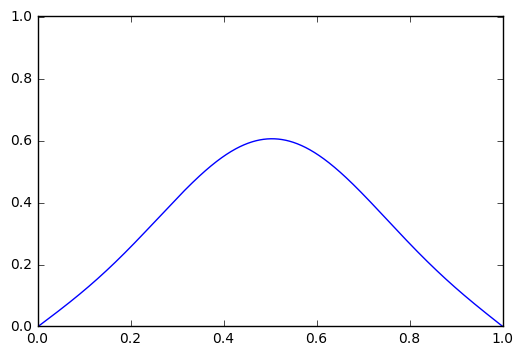

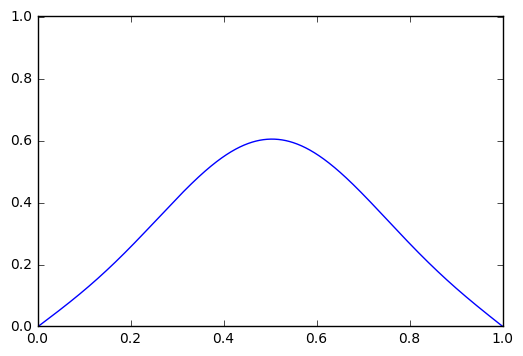

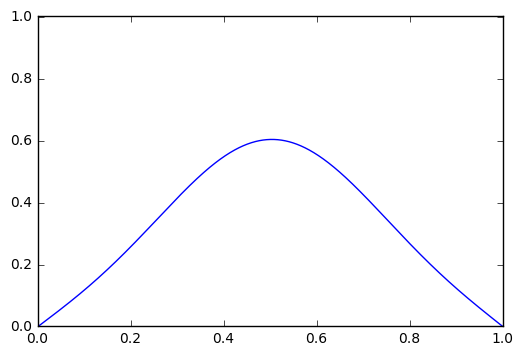

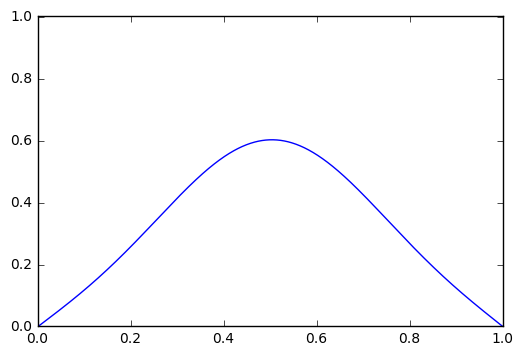

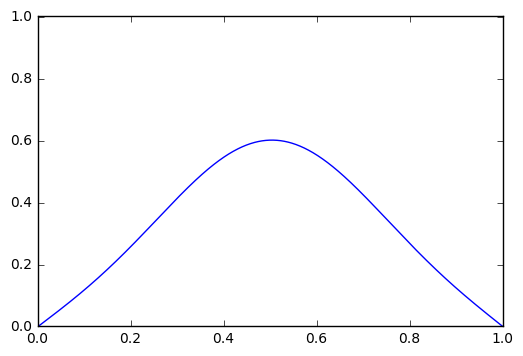

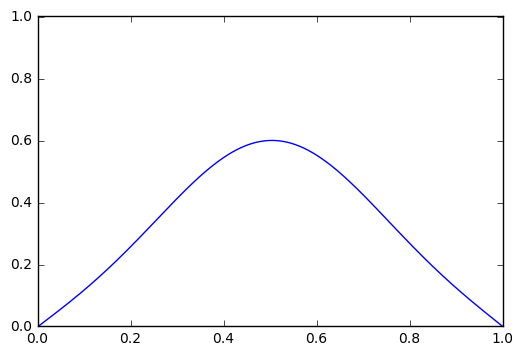

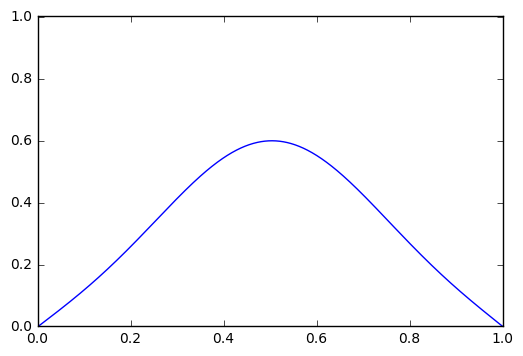

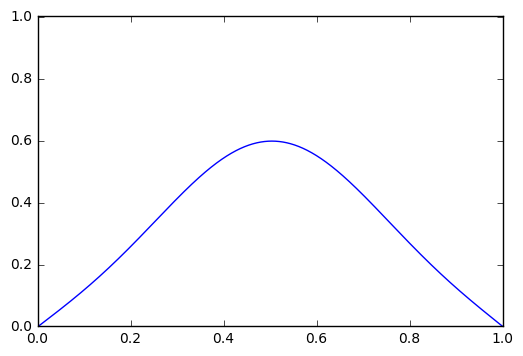

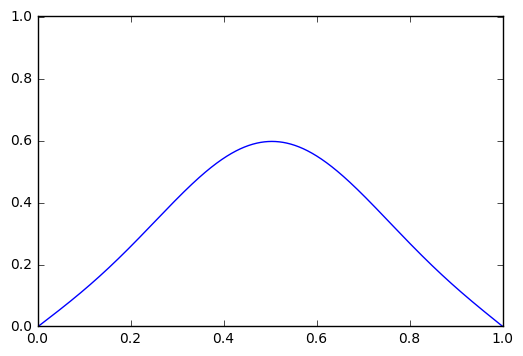

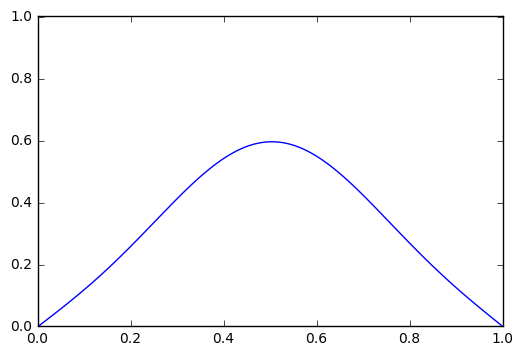

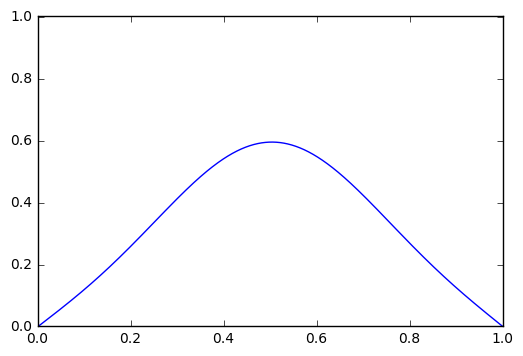

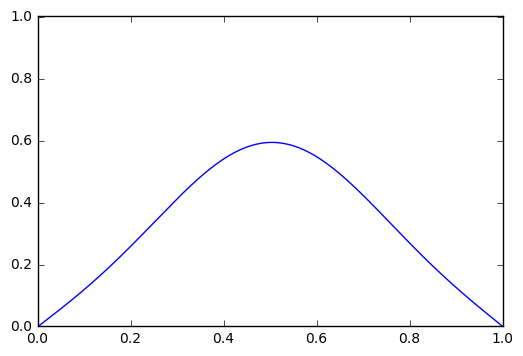

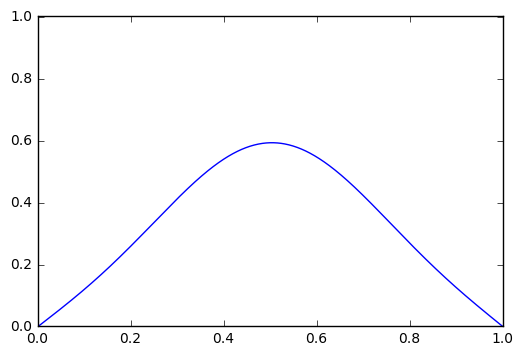

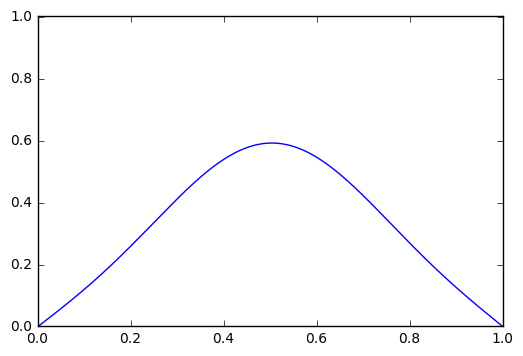

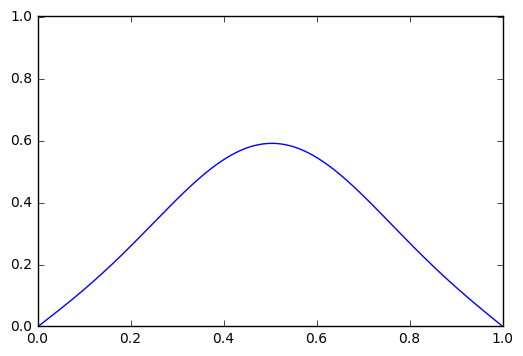

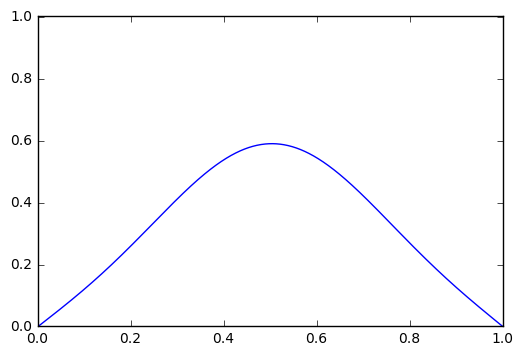

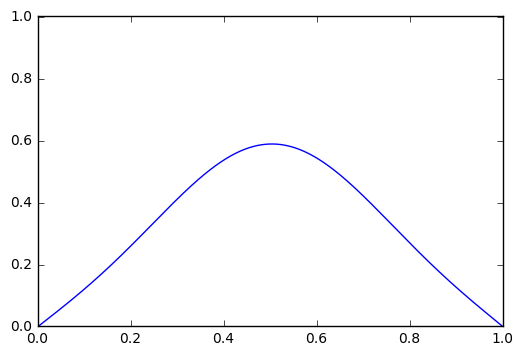

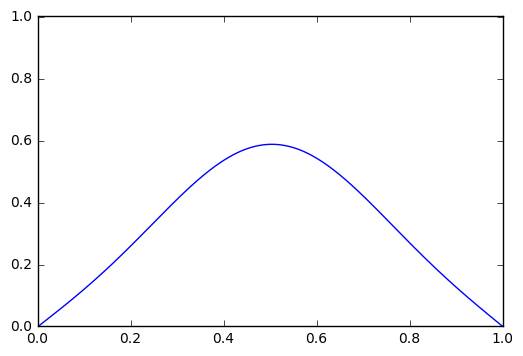

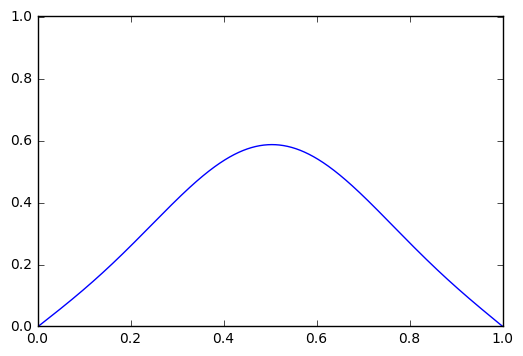

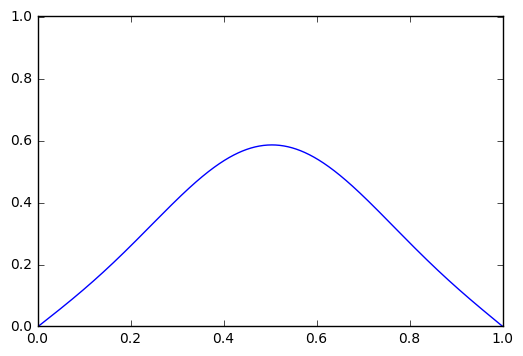

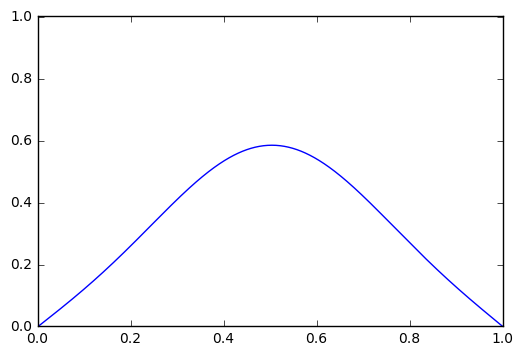

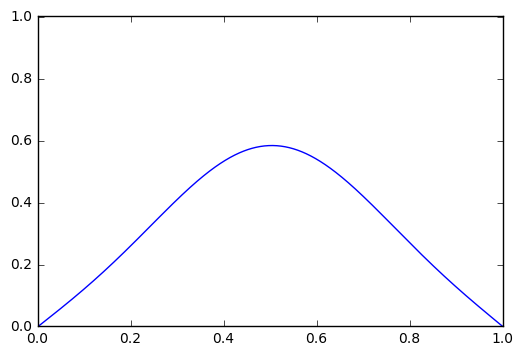

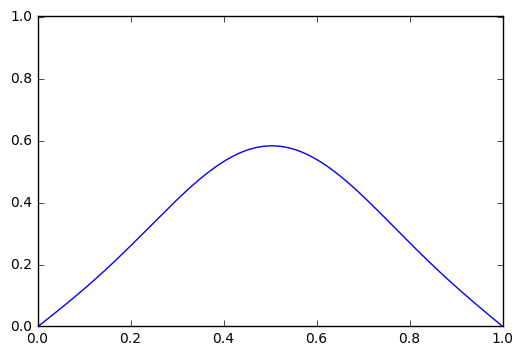

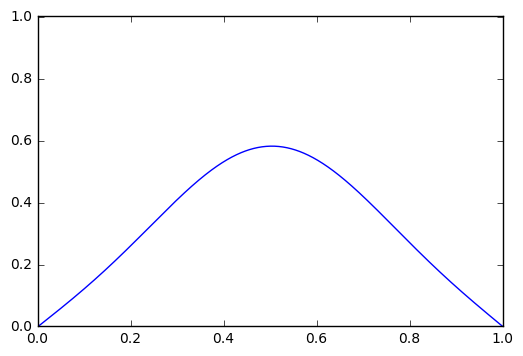

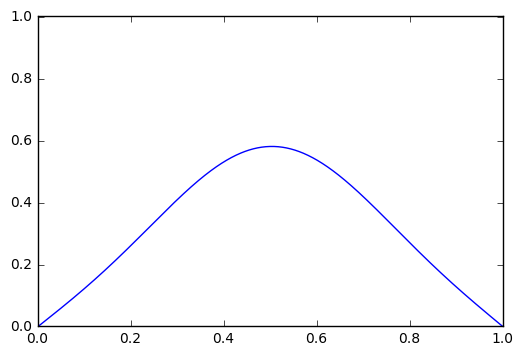

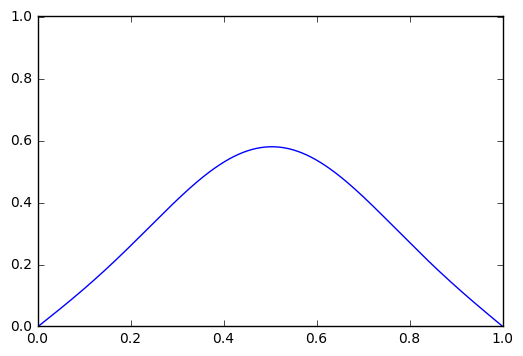

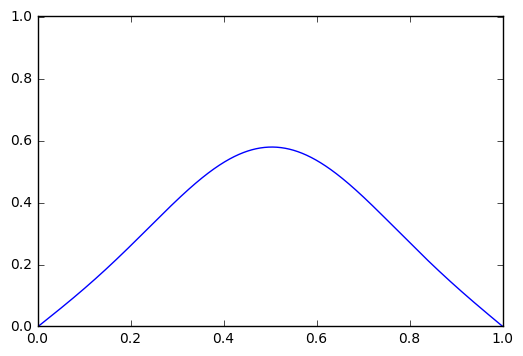

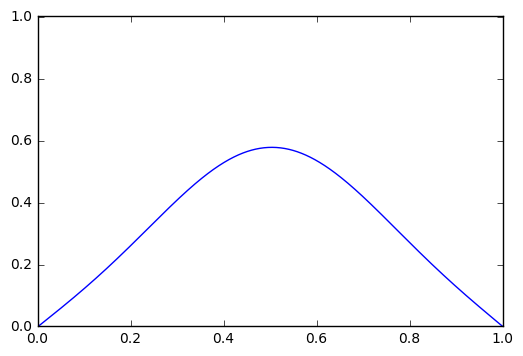

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import kstest,ks_2samp,uniform,chi2,chi2_contingency
import scipy.stats
from scipy.signal import periodogram

# the following code rewrites the example diffusion function, diffusion1D.m, given in matlab
# except del2() function is implemented manually, del2() as follows, with the code given by Andrew in Slack.
# which looks like : Tnew(i) = T(i)  + C(T(i+1)-2*T(i)+T(i-1));

nx     = 1000      # number of grid points
L      = 1          # physical size of bar
alpha  = .001     # diffusivity
dt     =.0005      # timestep  
lbval  = 0.       # left and right boundary values
rbval  = 0.
dx     = L/nx       # grid spacing          
C = alpha*dt/(dx**2);   # for convenience
x=np.linspace(0,L,nx+2);     #in this case 1d Gaussian
T = np.exp(-(5*(x-0.5))**2) + .2*np.random.randn(1,nx+2)
T = T.transpose()
Tnew = np.zeros(len(T))
T[0] = lbval
T[-1] = rbval

# plot raw data T
plt.plot(x,T)
plt.show()      

def del2(): 
    
    for i in range(2,nx+1):
        Tnew[i] = T[i] + C*(T[i+1]-2*T[i]+T[i-1])

doplot = True
nsteps = 20000
snapshot_frequency = 100        
        
# diffusion1D demo
for n in range(1,nsteps+1):

    del2()

    # adjust the number of snapshots taken and set jump steps to 1000
    if (doplot and not n%snapshot_frequency):
        plt.plot(x,Tnew)
        plt.ylim(0,1.001)
        plt.show()

    T = Tnew
    T[0]=lbval
    T[-1]=rbval
    


## Generating dataset by taking snapshots, takes 30 seconds in my computer

In [92]:
# simulate diffusion config
# m is number of times diffusion runs
# n is number of snapshots sampled each time we run simulate_once()

# this version converges faster
# can be used to generate large amount of data
def del2():     
    
    for i in range(2,nx+1):
        Tnew[i] = T[i] + C*(T[i+1]-2*T[i]+T[i-1])

nsteps = 10000


# m: number of snapshots
# m: number of snapshots
# m: number of snapshots
m = 10
snapshot_frequency = nsteps/m


# final output dataset, which is input for question 1 
dataset= None

start = time.time()
    
for n in range(1,nsteps+1):

    del2()
        
    if not n%snapshot_frequency:   
        if dataset is None: 
            dataset = T.reshape(1,len(T))
        else: 
            dataset = np.concatenate((dataset,T.reshape(1,len(T))),axis=0)

    T = Tnew
    T[0]=lbval
    T[-1]=rbval
    
time_spent = time.time()-start

dataset = dataset.transpose()

print('mean(T): \n', np.mean(T))
print('Time spent: \n', time_spent)
print('input data shape:',dataset.shape)

mean(T): 
 0.30103653159
Time spent: 
 17.323309898376465
input data shape: (1002, 10)


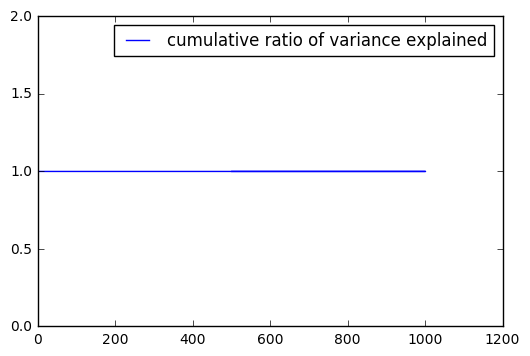

In [97]:
# Question - 1 (a)
# input data: dataset

def PCASimple(data):
    
    M,N = data.shape
    mn = np.mean(data,1)
    mn = mn.reshape(len(mn),1)

    data_mean_subtract = data - np.matlib.repmat(mn,1,N)
    
    # covariance matrix
    covar_matrix = np.cov(data_mean_subtract)
    eigenvalues, eigenvectors = np.linalg.eig(covar_matrix)
    V_sorted = list(np.sort(-1*eigenvalues))

    rindices = [V_sorted.index(x) for x in list(-1*eigenvalues)]
    
    #print(np.dot(eigenvectors[0],data))
    # return value: modes sorted by eigenvalues, sorted eigenvalues, eigenvectors, projected data
    V = eigenvalues[rindices]
    P = eigenvectors[:,rindices]
    Y = np.dot(P.transpose(),dataset) 
    
    return rindices,V,P,Y

# run PCAsimple function
rindices,v,p,projected_data = PCASimple(dataset)

# I don't think variance can be negative, so using abs()
explained_var = abs(v)/sum(abs(v))

# cumulative fraction of variance explained = cumulative sum(eigenvalues**2)/sum(eigenvalues**2)
plt.plot(rindices,np.cumsum(explained_var), label ="cumulative ratio of variance explained")
plt.ylim(0,2)
plt.legend()
plt.show()
print(np.cumsum(explained_var))

# Question 1(b)

The input data, called dataset, contains a table of size 10*1002, 10 snapshots. Feel free to modify the number of snapshots by changing variable m in the last cell.   

Wish I'm not doing it wrong, it looks so weird. According to the plotting right above, it seems like the first principal component can explain almost everything, which is given by the fact that the first element of cumulative sum array reaches 1.

Not sure why it is like that, seems like someone else also got this kind of result on slack. To benchmark my result, the following code calls PCA analysis provided by Python Scikit learn package, seems like it gets the same conclusion as I do with my own PCA(). Notice that PCA gives explained variance ratio, which is not cumulative, while in our case, it's cumulative. The first principal component explain 100%. 

In [98]:
from sklearn.decomposition import PCA
pca = PCA(n_components=m)
pca.fit(dataset.T)

# explained variance ratio by Scilearn PCA model
print(pca.explained_variance_ratio_) 

[  9.98739031e-01   1.26094039e-03   2.90097039e-08   1.06746959e-11
   5.08524415e-15   2.54420386e-19   3.66667760e-23   2.44426593e-28
   1.22041294e-29   5.30355806e-34]


# Question 1(c)

As far as I understand, this question asks us to remove the first principal component, because it explains 90% variance, well in my case, it's almost 100%. So I will remove the first principal component and later inverse transform PCA with components matrix without first component.  

NOTICE: I could not figure out exactly how to do this specific question, I can't find a tangible reference as a guidance. After spending so long tweaking my own version inverse transform, I decided to use Sklearn package to do it. I felt like can't trust my onw result.  

Looks like the dataset inverse transformed after removing the first principal component has exactly one curvy line compressed down the plotting. 

In [99]:
# inverse transform after removing the first principal component
data_reduced = np.dot(dataset, (pca.components_[:,1:]))
data_original = np.dot(data_reduced, pca.components_[:,1:].T)

inverse transform after cutting off at the 90% threshold of explained variance. 


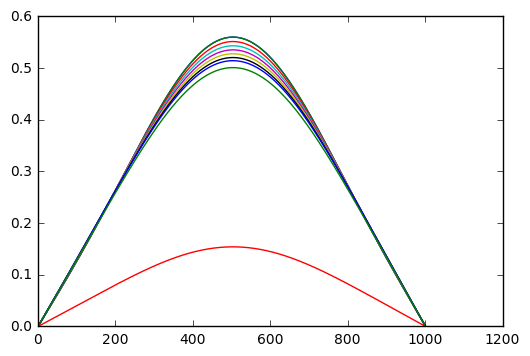

In [100]:
print('inverse transform after cutting off at the 90% threshold of explained variance. ')
plt.plot(data_original)
plt.show()

plot of original data


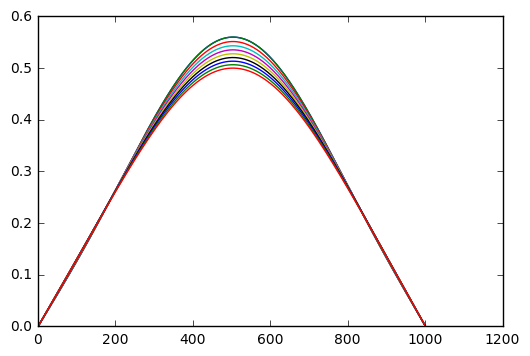

In [101]:
print('plot of original data')
# original data is called dataset in the code.
plt.plot(dataset)
plt.show()

# Question 1(d)

I think the data has been compressed very well. As the the follow plot shows, the first dimension of the compressed has a very large power in period 1 (maybe too inivisible but there actually is if we print it out), and the rest periods are very small relatively. Basically, other dimensions of the compressed data follow the same pattern. 

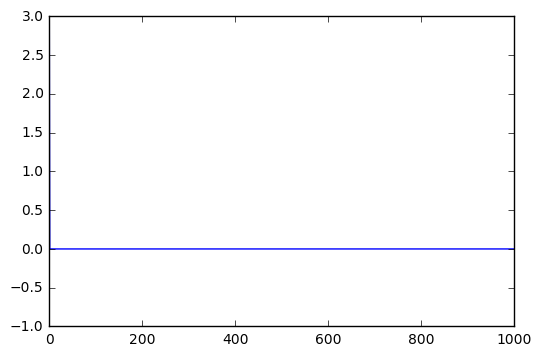

periodogram : [  2.94932589e+00   1.03885505e-30   1.05338750e-30 ...,   1.05998638e-31
   1.05338750e-30   1.03885505e-30]


In [140]:
# data_reduced is the compressed dataset
data_reduced = data_reduced - np.mean(data_reduced)

# get periodogram with fronrier frontier transform
xt_periodogram = np.abs(np.abs(np.fft.fft(data_reduced)))** 2

plt.plot(xt_periodogram[1,:])
plt.ylim(-1,3)
plt.show()
print('periodogram :',xt_periodogram[1,:])

# Question 2

After translating from matlab to python for question 1, I feel like question 2 maybe is cumbersome to translate again. So question 2 is written totally with Matlab, the example code is perfect as a started code. This is my first time using matlab, so pardon me if the way I organize the code is weird to you. 

observation is written out as comment in code. 

# Question 3 - Trapezoidal Rule: 

Because $f(x1; x2;...; x7)$ can be written as $\int e^{-x_1^2} dx_1 * \int e^{-x_2^2} dx_2...*\int e^{-x_7^2} dx_7$, we could apply trapezoidal rule with a function trapezoidal_integrate() applied to funct(), which is negative exponential, and $f(x1; x2;...; x7)$ as integral():

In [85]:
import numpy as np

def trapezoidal_integrate(f, lower, upper, strips=10000):
    
    dx = np.linspace(lower, upper, strips)
    dy = f(dx)    
    # compute area of trapezoidal (b-a) * (f(b) - f(a)) / 2
    area = np.sum((dy[1:]+dy[0:-1])*(dx[1:]-dx[0:-1]))/2

    return area
    
def funct(x):
    return np.exp(-x**2)

def integral():
    
    area = 1.0
    
    for i in range(7):
        area = area * trapezoidal_integrate(funct,0.0,1.0)
    return area
    
# results verified with wolforam
print('integral of e^(-x) from 0 to 1 =',trapezoidal_integrate(funct,0.0,1.0))
print('integral of f(x1, x2,... x7), each variable from 0 to 1 =',integral())

integral of e^(-x) from 0 to 1 = 0.746824132199
integral of f(x1, x2,... x7), each variable from 0 to 1 = 0.129577143062


# Question 3 - Monte Carlo: 

NOTICE: I think Monte Carlo converges much slower than the first method. like the first method gives fixed results with 10000 iterations, but monte carlo needs 100000 iterations to fix the first 3 digits after point, which means the result is still oscillating.

In [48]:
def integral(simulation_times= 100000):
    
    total =0.0
    
    for i in range(simulation_times):
        x = np.random.random(7)
        negative_exp_square = np.exp(-x**2.0)
        y = np.prod(negative_exp_square)
        total = total + y
        
    return total/simulation_times

integral()

0.12969841030689325

# Question 3 - Metropolis Hasting: 

Compared to Monte Carlo, Metropolis hasting is much faster. But it's still oscilating, I mean even if you specify the same arguments, and you run it several times, it gives different answers everytime. Of course, this conclusion is based on I implemented correctly. But I think we could do something to mitigate this issue, like run it several times and get the mean value. 

In [84]:
def metropolis_hasting(n=10000,m=2000):
    
    # x is chi, X, in notes
    x = np.zeros(n) 
    x_i_plus_1 = np.ones(n)

    for i in range(n-1):

        x_sample = np.random.random()
        # qxy(Y,X[i]) / qxy(X[i],Y)  
        current_hasting = (4/3.0 - x_sample**2) / (4/3.0 - x[i]**2) 
        u = np.random.rand()

        if (u <= current_hasting):
            x[i+1] = x_sample
            x_i_plus_1[i+1] = 1

        else:
            x[i+1] = x[i]
            x_i_plus_1[i+1] = 0
            
    x = x[m:]
        
    return np.mean(np.exp(-x ** 2)/(4./3 - x**2))


def integrate():
    
    product = 1
    
    for i in range(7):
        product = product*metropolis_hasting()
        
    return product
        
print('integral of f(x1, x2,... x7), each variable from 0 to 1 =',integrate())

0.129520836997
